# Flood Adaptation: Minimal Model

This python script outlines a basic Agent-Based Model (ABM) developed using the Mesa framework, designed as a simplified representation of household adaptation to flood events in a social network context. The model serves as a template for understanding the fundamental mechanics of flood adaptation with a given social network.

This directory is structured as follows:
 - A Mesa Agent class `Households` is defined in `agents.py`
 - A Mesa Agent class `Government` is defined in `agents.py` 
 - A Mesa Agent class `Government Implementation` is defined in `agents.py` 
 - A Mesa Agent class `Media` is defined in `agents.py` 
 - A Mesa Agent class `Insurance` is defined in `agents.py` 
 - A Mesa Model class `AdaptationModel` is defined in `model.py`
 - This notebook `demo.ipynb` provides a demonstration of the model and its visualization.

Each household agent in the model represents a household with attributes and behaviors that determine its response to flood events. They can move to a higher location or barickade the house or place sand bags. 

The current implementation includes a division of the floodmap into zones (currently just along the y axis). It also bases the floods on actual rain data of the past. It still takes a random sample but it could be seen as an actual environment.

This notebook will supply graphs and analysis to further understand the model

A few notes:

The amount of policies are hard coded to not be higher than 10. They will be placed on low locations, it protects the area within reason against heavy rainfall thus higher water. 
The economy is very simple and is more there to provide a cap on the adaptation measures for households.
The economy can be made inequal by setting the variable intorduce inequelity to True, this is inspried by the simple economy model, but even simpler.

_This notebook was tested on 2023-11-13 with Mesa version 2.1.4 on Python 3.12.0._

Model will run for 80 ticks where each tick is 1/4 of a year.

# Running the model and visualizing the model domain and social network over time

First define the variables and settings for the model in the cell below

Some sources:

- average income of a household in Houston Texas is 60k per year so 15K for 1/4 of a year: https://www.census.gov/quickfacts/fact/table/houstoncitytexas/INC110222
- Start income will be normally distributed with a mean of 46k: https://www.valuepenguin.com/banking/average-savings-account-balance
- The Texas government spends between 17.5 and 20k per household already in the model: https://www.bls.gov/regions/southwest/news-release/consumerexpenditures_houston.htm
- Tax rates in the model roughly based on the following https://smartasset.com/taxes/texas-tax-calculator#sTLF6Zq0sl
- Other government incomes are also coded to stabilise the money flow https://comptroller.texas.gov/transparency/revenue/watch/#:~:text=The%20largest%20sources%20of%20state,motor%20vehicle%2Drelated%20taxes 


In [1]:
#select if you want to write to the logging file yes/no

logging = False #warning! setting this to true leads to loss in performance please only use for debugging.

In [2]:
#start the running of multiple models

number_of_households = 50 #recommended 
number_of_zones = 2 #number of zones the floodmap will be devided into 
household_income_mean = 15000 #mean of the normal curve of income
government_implementations = True #are the implementations on or off
insurance = False #if there is an insurance model
flood_map_choice = "harvey" #type of flood map: other choices 100yr and 500yr
network="watts_strogatz" #type of network: other choices are 'erdos_renyi', 'barabasi_albert', 'watts_strogatz', and 'no_network'
adaptation_threshold=0.5 #at what prospect score should the households adapt, this score is between 0 and 1, recommended to let this be 0.5
initial_government_cash = 10000000 #Leave this high so the government can make some implementations because households start off by paying little taxes,
introduce_inequality=True #inequality in the economy yes/no
number_of_steps=80 #recommended to leave this at 80

c:\Users\vandi\AppData\Local\Programs\Python\Python39\lib\site-packages\mesa\time.py:79: FutureWarning: The AgentSet is experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1919
  self._agents: AgentSet = AgentSet(agents, model)


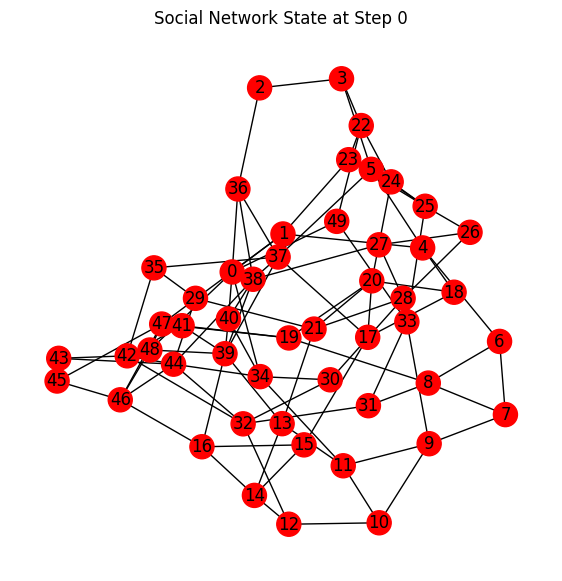

Running the model for 80 steps


<Figure size 1000x600 with 0 Axes>

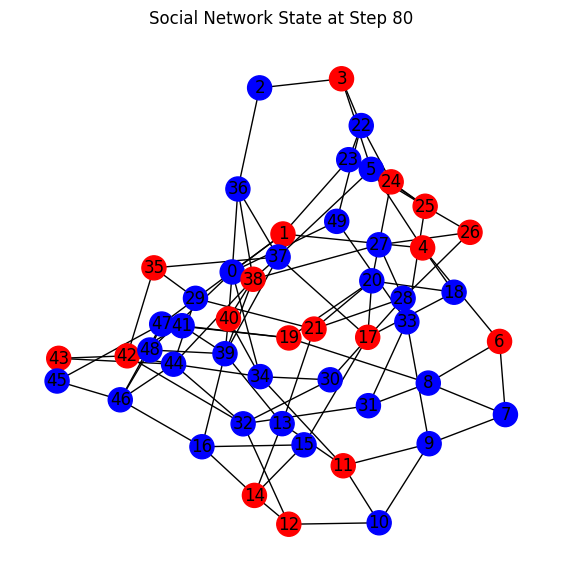

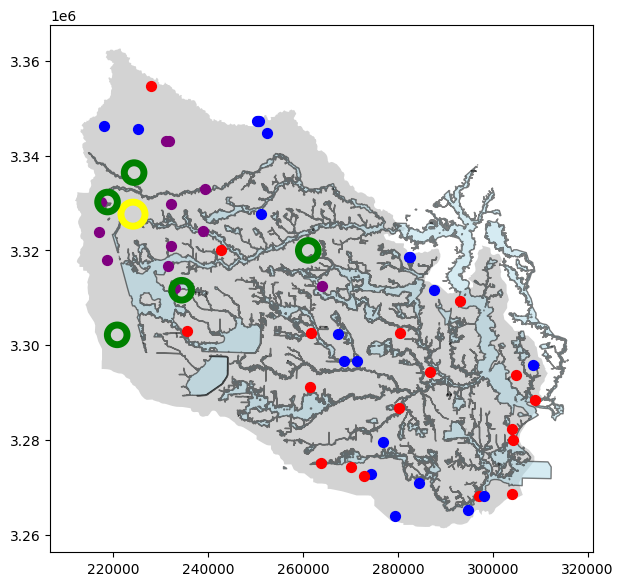

In [3]:
from model import AdaptationModel
import matplotlib.pyplot as plt
import networkx as nx
from functions import map_domain_gdf, floodplain_gdf

# Initialize the Adaptation Model with 50 household agents.
model = AdaptationModel(
    logging = logging,
    number_of_households=number_of_households, 
    number_of_zones=number_of_zones, 
    flood_map_choice=flood_map_choice, 
    network=network, 
    insurance=insurance,
    government_implementations=government_implementations,
    adaptation_threshold=adaptation_threshold, 
    government_money=initial_government_cash,
    introduce_inequality=introduce_inequality, 
    number_of_steps=number_of_steps) # flood_map_choice can be "harvey", "100yr", or "500yr"
# Calculate positions of nodes for the network plot.
# The spring_layout function positions nodes using a force-directed algorithm,
# which helps visualize the structure of the social network.
pos = nx.spring_layout(model.G)

# Define a function to plot agents on the network.
# This function takes a matplotlib axes object and the model as inputs.
def plot_network(ax, model):
    # Clear the current axes.
    ax.clear()
    # Determine the color of each node (agent) based on their adaptation status
    household_agents = []
    government_implementations = [] # does not do much now
    for agent in model.schedule.agents:
        if agent.type == 'household':
            household_agents.append(agent)
        if agent.type == "implementation":
            government_implementations.append(agent)
        
    colors = ['blue' if agent.is_adapted else 'red' for agent in household_agents]

    # Draw the network with node colors and labels.
    nx.draw(model.G, pos, node_color=colors, with_labels=True, ax=ax)
    # Set the title of the plot with the current step number.
    ax.set_title(f"Social Network State at Step {model.schedule.steps}", fontsize=12)

# Plot the initial state of the social network.
fig, ax = plt.subplots(figsize=(7, 7))
plot_network(ax, model)
plt.show()

# Run the model for 20 steps and generate plots every 5 steps.
print(f"Running the model for {model.number_of_steps} steps")
for step in range(model.number_of_steps):
    model.step()

    # Every 5 steps, generate and display plots for both the spatial distribution and network.
    # Note the first step is step 0, so the plots will be generated at steps 4, 9, 14, and 19, which are the 5th, 10th, 15th, and 20th steps.
    if step  == model.number_of_steps-1:
        # Plot for the spatial map showing agent locations and adaptation status.
        plt.figure(figsize=(10, 6))
        #model.plot_model_domain_with_agents()
        # Plot for the social network showing connections and adaptation statuses.
        fig, ax = plt.subplots(figsize=(7, 7))
        plot_network(ax, model)
        plt.show()

# Plot the model domain
fig, ax = plt.subplots(figsize=(7, 7))
map_domain_gdf.plot(ax=ax, color='lightgrey')
#Plot the floodplain
floodplain_gdf.plot(ax=ax, color='lightblue', edgecolor='k', alpha=0.5)
for agent in model.schedule.agents:
    if agent.type == "household" and agent.is_adapted == False:
        #get position on the map
        ax.scatter(agent.location.x, agent.location.y, color='red', s=50)  # Bigger, hollow circle
    elif agent.type == 'household':
        if agent in model.adapted_because_government:
            ax.scatter(agent.location.x, agent.location.y, color='purple', s=50)  # Smaller, filled circle
        else:
            ax.scatter(agent.location.x, agent.location.y, color='blue', s=50)  # Smaller, filled circle
    elif agent.type == "implementation":
        if agent.policy == "Dikes":
            ax.scatter(agent.location.x, agent.location.y, facecolors = "none", linewidths=5, edgecolors='green', s=200) 
        elif agent.policy == "Water locks":
            ax.scatter(agent.location.x, agent.location.y, facecolors = "none", linewidths=5, edgecolors='yellow', s=300) 

    

<h1><b> Data Analysis </h1></b>

For the data analysis there are 3 chapters:

<b> -Single model analysis </b>
    <p>here the economy, adaptation, reasons for adaptation, implementations, flood data and media coverage are visualised and analysed. Here the outcome can be different, in my experience about 1/3 of the runs have enough rainfall for government action. These models are a bit more exiting on the analysis part</p>

<b> -Multi model runs </b>
    <p>here the model will run 100 times to account for some of the randomness.</p>
    
<b> Final takeaways and conclusions </b>
    <p>Here some final remarks will be made</p>


In the cell below all the different types of <b>agent_data</b> data will be categorised in their own pandas dataframe. We have chosen for the household, government and implementation data as the insurance and media do not carry a lot of usefull data.

In [4]:
agent_data = model.datacollector.get_agent_vars_dataframe()
household_data = agent_data
government_data = agent_data
implementation_data = agent_data

#filter the data sets
for i, j in enumerate(agent_data.Type[model.number_of_steps -1]):
    if j != "household":
        household_data = household_data.drop(i, level='AgentID') #drop media and government
    if j != 'implementation':
        implementation_data = implementation_data.drop(i, level='AgentID')
    if j != 'government':
        government_data = government_data.drop(i, level='AgentID')
household_data.tail()

Type  FloodDepthEstimated  FloodDamageEstimated  \
Step AgentID                                                         
79   45       household                  0.0                   0.0   
     46       household                  0.0                   0.0   
     47       household                  0.0                   0.0   
     48       household                  0.0                   0.0   
     49       household                  0.0                   0.0   

              FloodDepthActual  FloodDamageActual IsAdapted Currentadaptation  \
Step AgentID                                                                    
79   45                    1.2           0.680133      True          SandBags   
     46                    0.0           0.000000      True   GovernmentBased   
     47                    1.2           0.226711      True              Move   
     48                    0.0           0.000000      True   GovernmentBased   
     49                    1.2           0.680133      True          SandBags   

                     Money IsInsured  FriendsCount  \
Step AgentID                                         
79   45       53094.205846     False           3.0   
     46       81787.058277     False           5.0   
     47       58448.315284     False           5.0   
     48       62820.270378     False           4.0   
     49       63835.577916     False           3.0   

                                                   location  
Step AgentID                                                 
79   45         POINT (308555.7865925819 3295799.589948845)  
     46        POINT (218651.6003226035 3317998.1477247598)  
     47       POINT (282378.71193072124 3318712.5188323096)  
     48         POINT (231669.1864285606 3343091.554059087)  
     49       POINT (294699.88639828796 3265308.8302197936)

The cell below shows the first few agents and their data, so mostly initial data.

In [5]:
agent_data_insured = agent_data.loc[agent_data['IsInsured']==True]
agent_data_insured.tail()

Empty DataFrame
Columns: [Type, FloodDepthEstimated, FloodDamageEstimated, FloodDepthActual, FloodDamageActual, IsAdapted, Currentadaptation, Money, IsInsured, FriendsCount, location]
Index: []

The below cell prepares the economic data so it can be plotted. The data resembles the money of the household per agent. This is a list for each agent, the list has an equal length as the number of steps because it tracks the money of each agent during the model run. This will be vastly different if the inequality variable is set to true when initialising the model

In [6]:
import pandas as pd
import numpy as np

household_data_per_agent = {}

for i in range(model.number_of_households):
    household_data_per_agent[i] = []

loop = 0
for i in household_data.Money:
    if loop == (model.number_of_households-1):
        loop = 0
        
    household_data_per_agent[loop].append(i)
    loop += 1

household_data_per_agent_dataset = pd.DataFrame([household_data_per_agent])
household_data_per_agent_dataset = household_data_per_agent_dataset.transpose()
household_data_per_agent_dataset.columns = ['Money']
household_data_per_agent_dataset.index.name = 'Agents'
household_data_per_agent_dataset.head()

Money
Agents                                                   
0       [8112.654113034547, 20750.09143132015, 23666.5...
1       [21179.343627242073, 10251.670324986671, 30383...
2       [14626.279273874392, 41002.1774222979, 18887.0...
3       [16325.931962554678, 33961.1419082603, 57002.7...
4       [16621.47752148531, 24832.702373430482, 41486....

Use below cell to view the government data at the start of the model, not all columns are used so it is a bit cluttered now and each step there is obviously only one government agent

In [7]:
government_data.tail()

Type  FloodDepthEstimated  FloodDamageEstimated  \
Step AgentID                                                          
75   51       government                  NaN                   NaN   
76   51       government                  NaN                   NaN   
77   51       government                  NaN                   NaN   
78   51       government                  NaN                   NaN   
79   51       government                  NaN                   NaN   

              FloodDepthActual  FloodDamageActual IsAdapted Currentadaptation  \
Step AgentID                                                                    
75   51                    NaN                NaN      None              None   
76   51                    NaN                NaN      None              None   
77   51                    NaN                NaN      None              None   
78   51                    NaN                NaN      None              None   
79   51                    NaN                NaN      None              None   

                     Money IsInsured  FriendsCount location  
Step AgentID                                                 
75   51       7.720704e+06      None           NaN     None  
76   51       7.972788e+06      None           NaN     None  
77   51       8.116998e+06      None           NaN     None  
78   51       8.054050e+06      None           NaN     None  
79   51       8.239397e+06      None           NaN     None

The implementation data keeps track of all the implementations the government has executed. This can be noting Dikes and Water locks. Dikes provide 2 times less protection than waterlocks do against regional flooding. 

In [8]:
implementation_data.tail()

Type  FloodDepthEstimated  FloodDamageEstimated  \
Step AgentID                                                              
79   54       implementation                  NaN                   NaN   
     55       implementation                  NaN                   NaN   
     56       implementation                  NaN                   NaN   
     57       implementation                  NaN                   NaN   
     58       implementation                  NaN                   NaN   

              FloodDepthActual  FloodDamageActual IsAdapted Currentadaptation  \
Step AgentID                                                                    
79   54                    NaN                NaN      None              None   
     55                    NaN                NaN      None              None   
     56                    NaN                NaN      None              None   
     57                    NaN                NaN      None              None   
     58                    NaN                NaN      None              None   

              Money IsInsured  FriendsCount  \
Step AgentID                                  
79   54         NaN      None           NaN   
     55         NaN      None           NaN   
     56         NaN      None           NaN   
     57         NaN      None           NaN   
     58         NaN      None           NaN   

                                                   location  
Step AgentID                                                 
79   54          POINT (224396.779805948 3336414.913011829)  
     55         POINT (261116.5140343442 3320010.891127813)  
     56        POINT (220828.7766425481 3302212.2955123857)  
     57       POINT (218796.37738892357 3330216.0575292255)  
     58        POINT (234399.56777506863 3311617.350120336)

The model data shows all the variables the model kept track off

In [9]:
model_data = model.datacollector.get_model_vars_dataframe()
model_data

total_adapted_households  media_coverage  number_of_floods current_policy  \
0                          0               0                 0      No policy   
1                         14               0                 0      No policy   
2                         14               0                 0      No policy   
3                         15               0                 0      No policy   
4                         15               0                 0      No policy   
..                       ...             ...               ...            ...   
75                        32               1                10          Dikes   
76                        33               1                10          Dikes   
77                        33               1                10          Dikes   
78                        31               1                10          Dikes   
79                        32               1                10          Dikes   

                    AdaptedByGovernmentImplementation  moneySpentOnPrevention  \
0   [<agents.Households object at 0x000002435239A3...                       0   
1   [<agents.Households object at 0x000002435239A3...                       0   
2   [<agents.Households object at 0x000002435239A3...                       0   
3   [<agents.Households object at 0x000002435239A3...                       0   
4   [<agents.Households object at 0x000002435239A3...                       0   
..                                                ...                     ...   
75  [<agents.Households object at 0x000002435239A3...                 8000000   
76  [<agents.Households object at 0x000002435239A3...                 8000000   
77  [<agents.Households object at 0x000002435239A3...                 8000000   
78  [<agents.Households object at 0x000002435239A3...                 8000000   
79  [<agents.Households object at 0x000002435239A3...                 8000000   

    householdFinancialDamage  
0               0.000000e+00  
1               0.000000e+00  
2               0.000000e+00  
3               0.000000e+00  
4               0.000000e+00  
..                       ...  
75              1.316045e+07  
76              1.316045e+07  
77              1.316045e+07  
78              1.316045e+07  
79              1.316045e+07  

[80 rows x 7 columns]

This cell saves and shows the households that have adapted because of a government implementation. Implementations are now placed randomly on the map that could be less effective.

In [10]:
agents = model_data["AdaptedByGovernmentImplementation"]
agents_adapted_by_government = []

for i in agents:
    if i != None and len(i) > 0:
        agents_adapted_by_government = i

print(agents_adapted_by_government)

print(f"Amount of agents adapted by the government measures {len(agents_adapted_by_government)}")

[<agents.Households object at 0x000002435239A310>, <agents.Households object at 0x000002437F750400>, <agents.Households object at 0x000002437F750F40>, <agents.Households object at 0x000002437F7507C0>, <agents.Households object at 0x000002437F750790>, <agents.Households object at 0x000002437F750A30>, <agents.Households object at 0x000002437F750E80>, <agents.Households object at 0x00000243511EF1C0>, <agents.Households object at 0x000002437F7045E0>, <agents.Households object at 0x000002437F704E80>, <agents.Households object at 0x000002437F750EE0>, <agents.Households object at 0x000002437F750B50>]
Amount of agents adapted by the government measures 12


This cell provides graphs on the economics of the government and households

<AxesSubplot: title={'center': 'Type of adaptation of each household'}, xlabel='adaptation type', ylabel='Amount'>

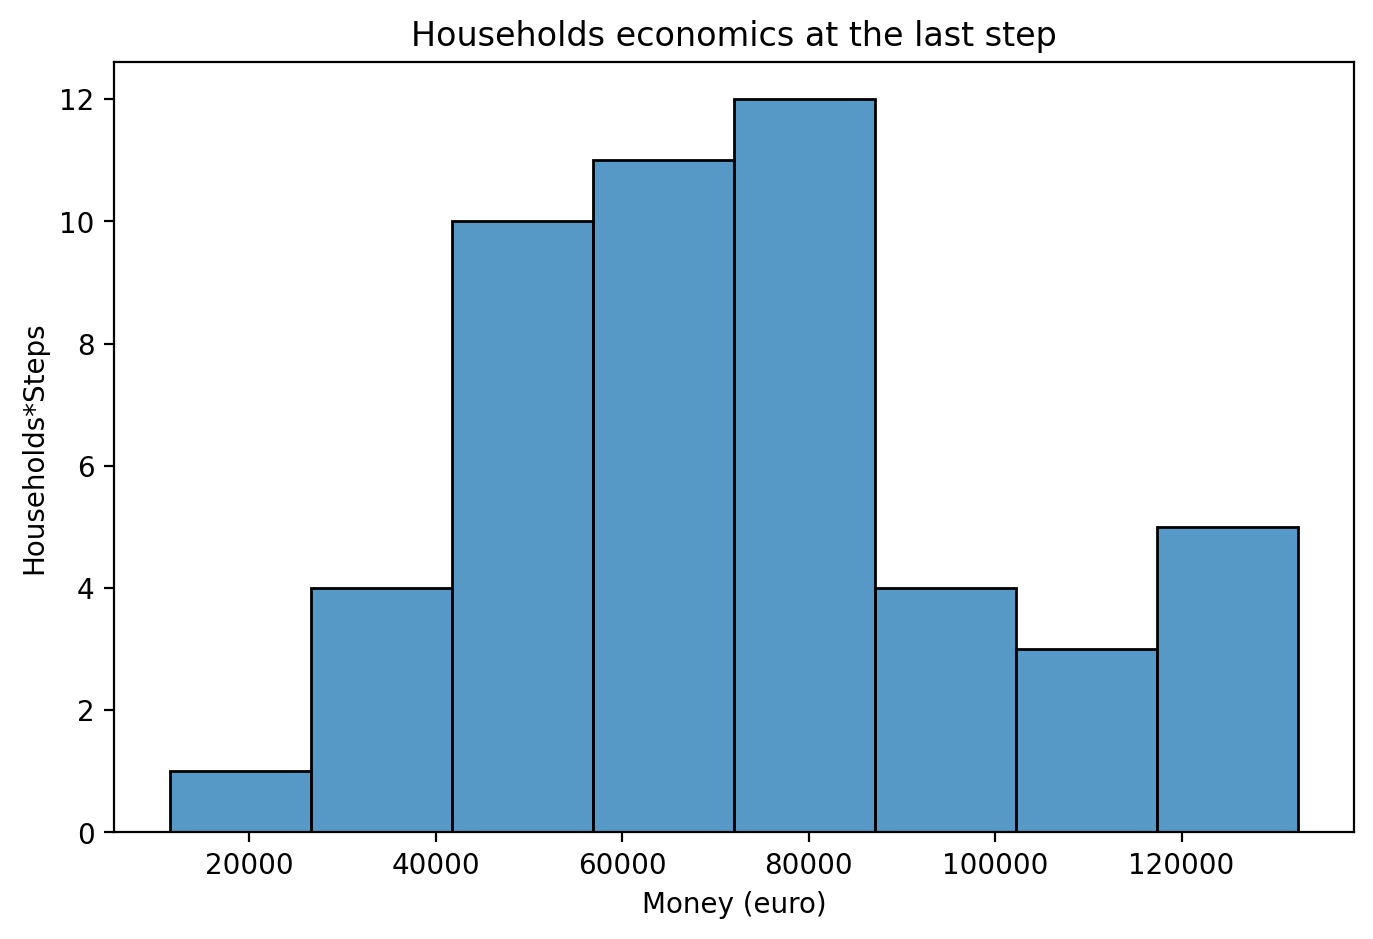

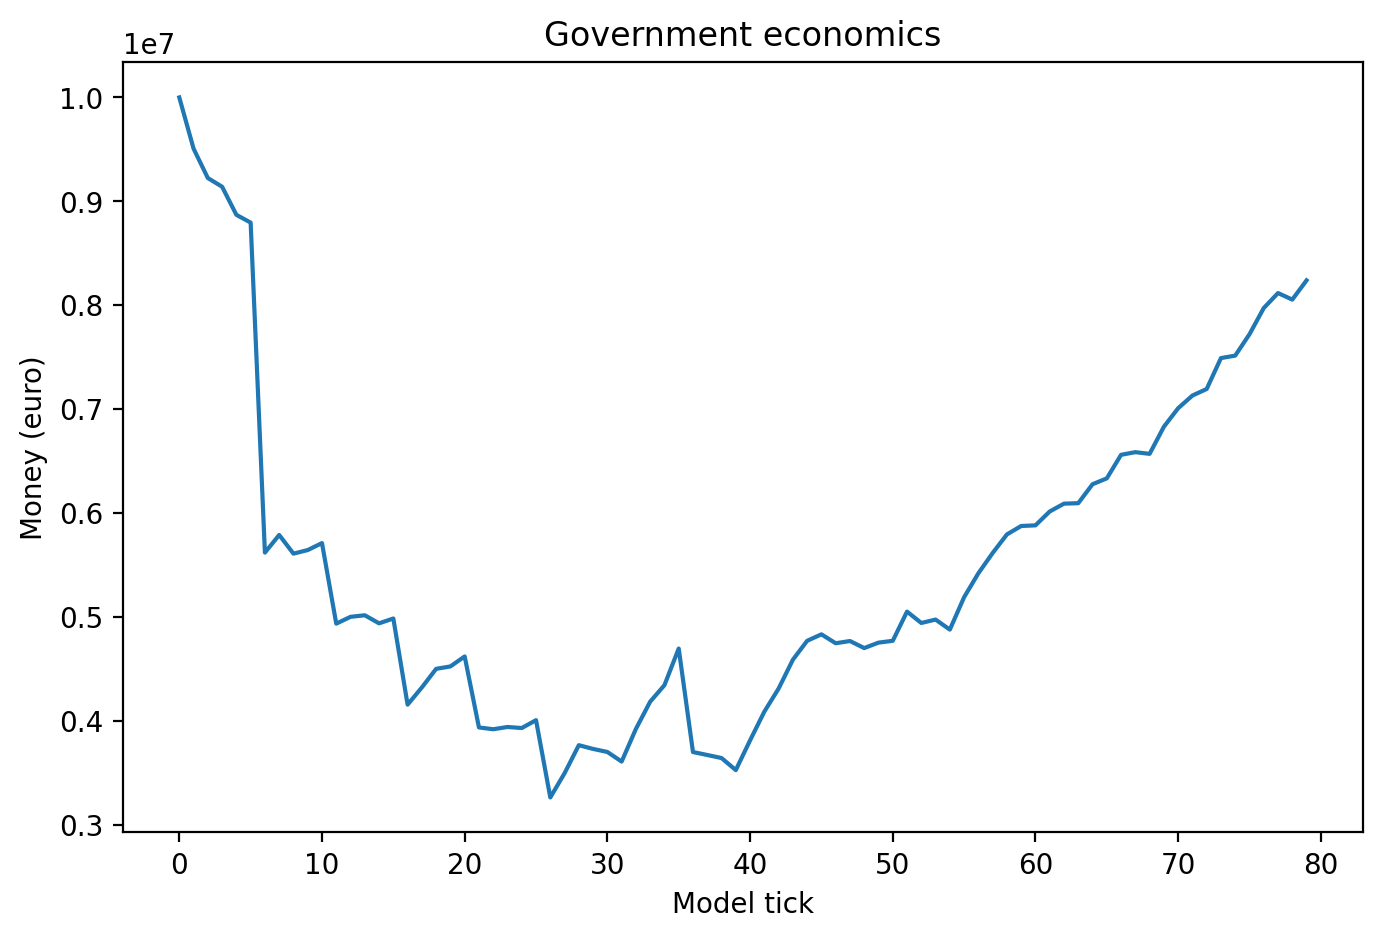

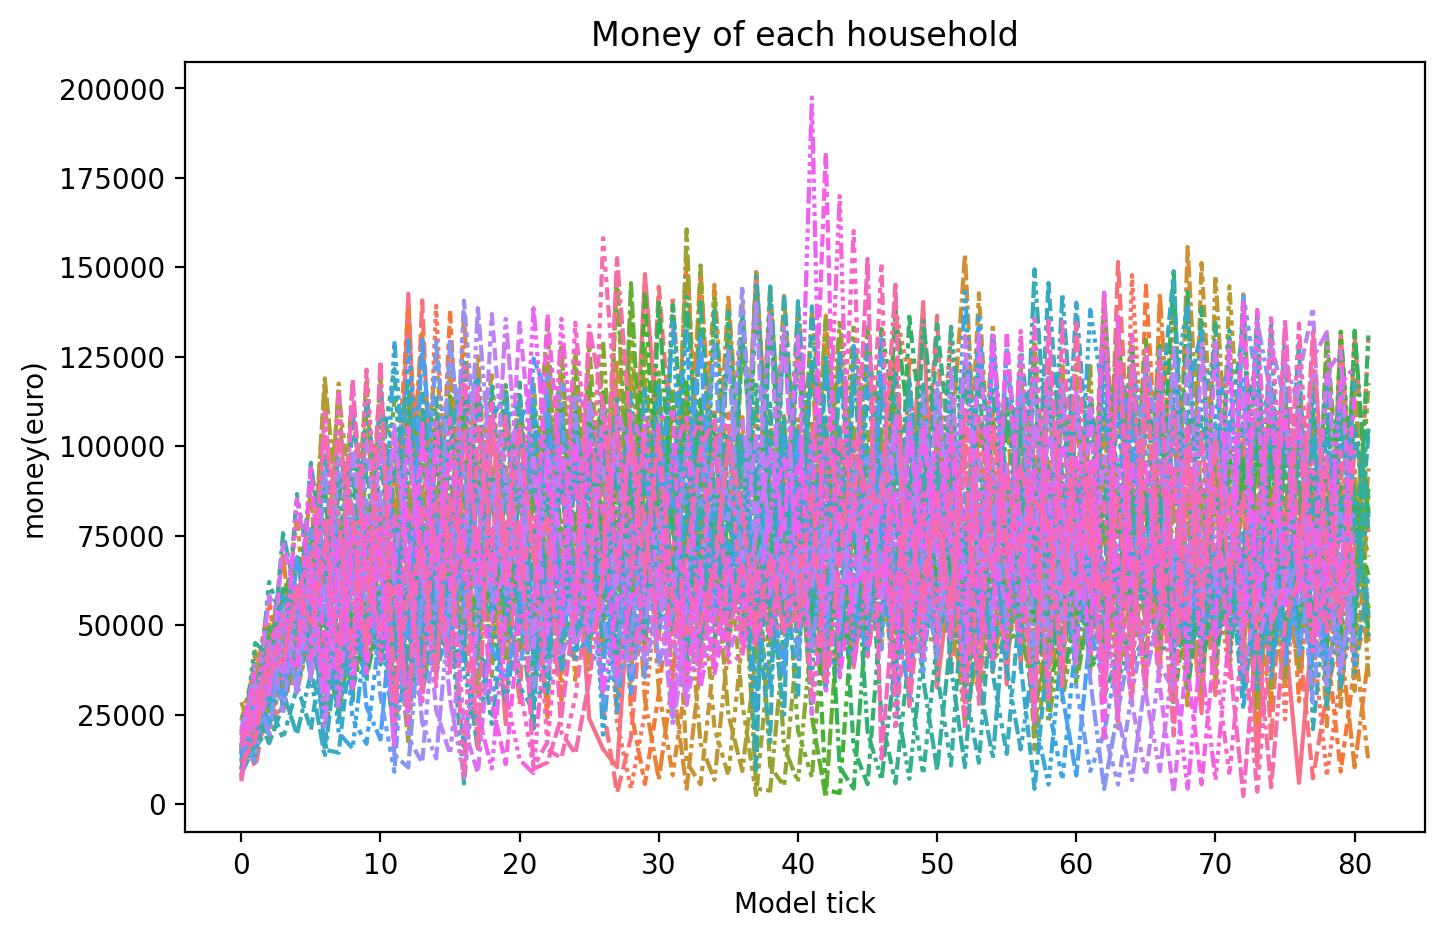

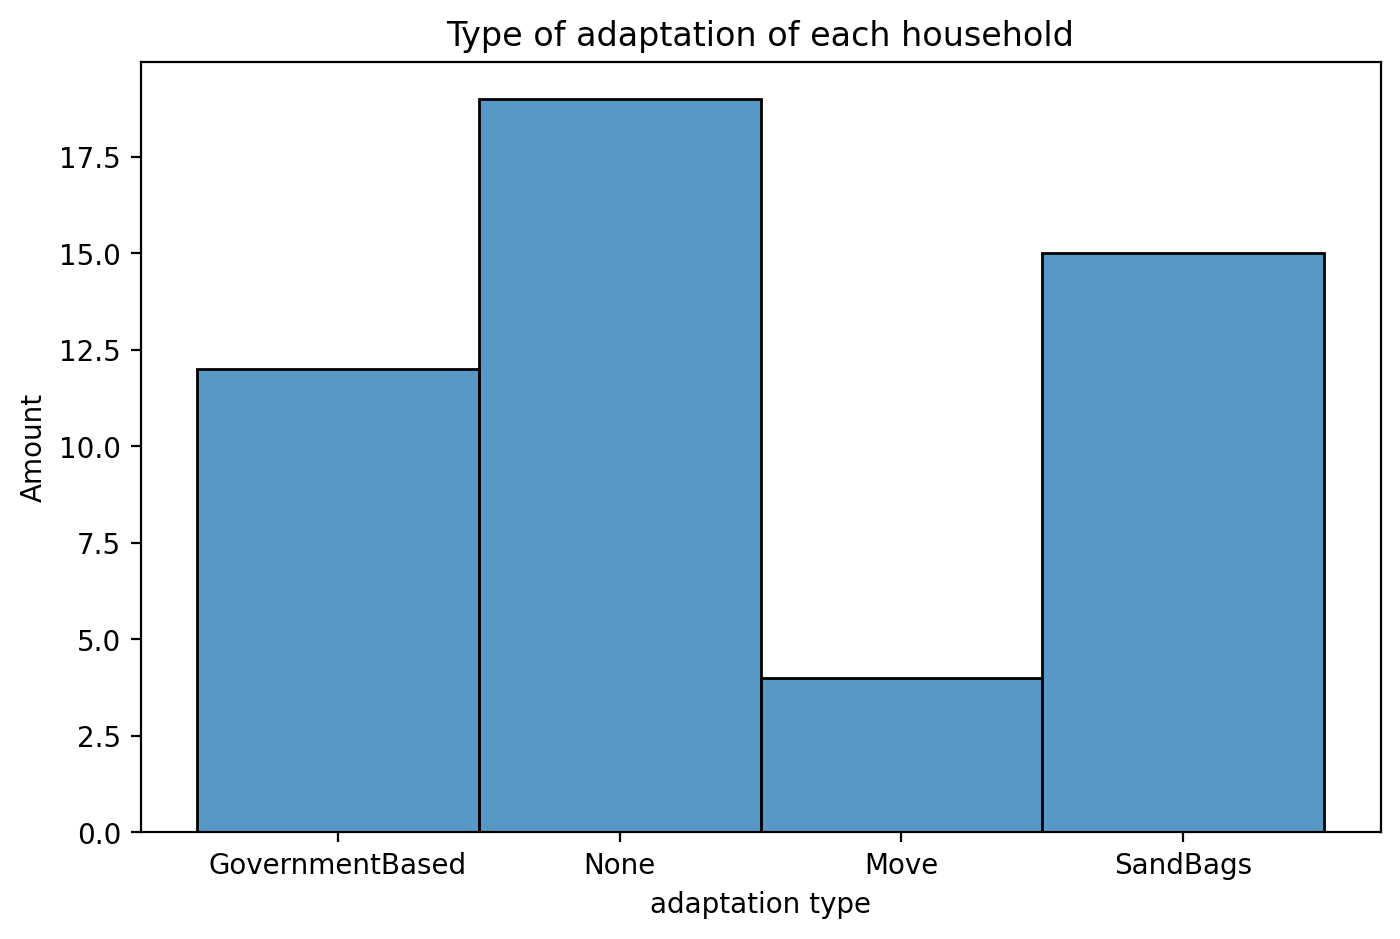

In [11]:
import seaborn as sns

#You will see that agents adapt at step 5 most because then the flood happened and only then the media will have influance on it.

fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title("Households economics at the last step")
ax.set_xlabel("Money (euro)")
ax.set_ylabel("Households*Steps")
sns.histplot(data = household_data["Money"][model.number_of_steps-1] )

#You will see that agents adapt at step 5 most because then the flood happened and only then the media will have influance on it.

fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title("Government economics")
ax.set_xlabel("Model tick")
ax.set_ylabel("Money (euro)")
sns.lineplot(data = government_data.Money.to_list())

#You will see that agents adapt at step 5 most because then the flood happened and only then the media will have influance on it.

fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title("Money of each household")
ax.set_xlabel("Model tick")
ax.set_ylabel("money(euro)")
sns.lineplot(data = household_data_per_agent, legend=None)

#The current adaptation
fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title("Type of adaptation of each household")
ax.set_xlabel("adaptation type")
ax.set_ylabel("Amount")
sns.histplot(data = household_data["Currentadaptation"][model.number_of_steps-1])

This Graph shows how many agents are insured at the last model step, the model is now coded in a way that people stay insured when they adapt.

<AxesSubplot: title={'center': 'Insured households step 80'}, xlabel='Insured (1), Not insured(0)', ylabel='Amount of households'>

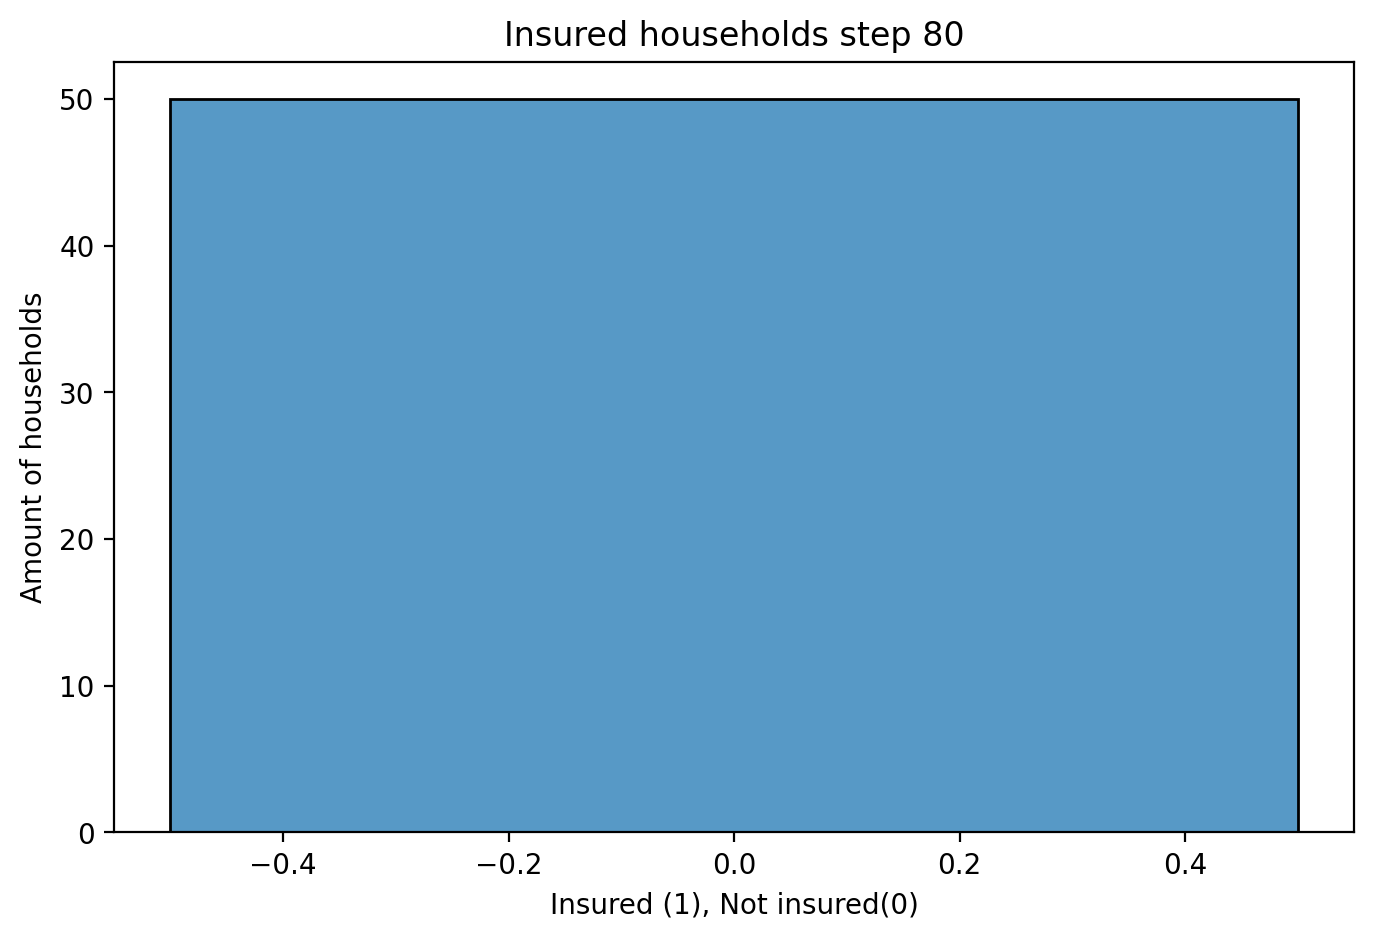

In [12]:
insured_end_of_model = household_data["IsInsured"][model.number_of_steps-1]
#You will see that agents adapt at step 5 most because then the flood happened and only then the media will have influance on it.
fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title(f"Insured households step {model.number_of_steps}")
ax.set_xlabel("Insured (1), Not insured(0)")
ax.set_ylabel("Amount of households")
sns.histplot(data = insured_end_of_model, legend=None)

The following graph shows the amount of households that got adapted, the media coverage and the amount of floods in the model. It also shows the flipover in policy choices in the model. Floods are less likely as there are more government implementations but are also quite aggressively programmed for demonstration purposes. floods now accure with rainfall of more that 30 mm/hour 

<AxesSubplot: title={'center': 'Policy changes over time'}, xlabel='Model tick', ylabel='Policy'>

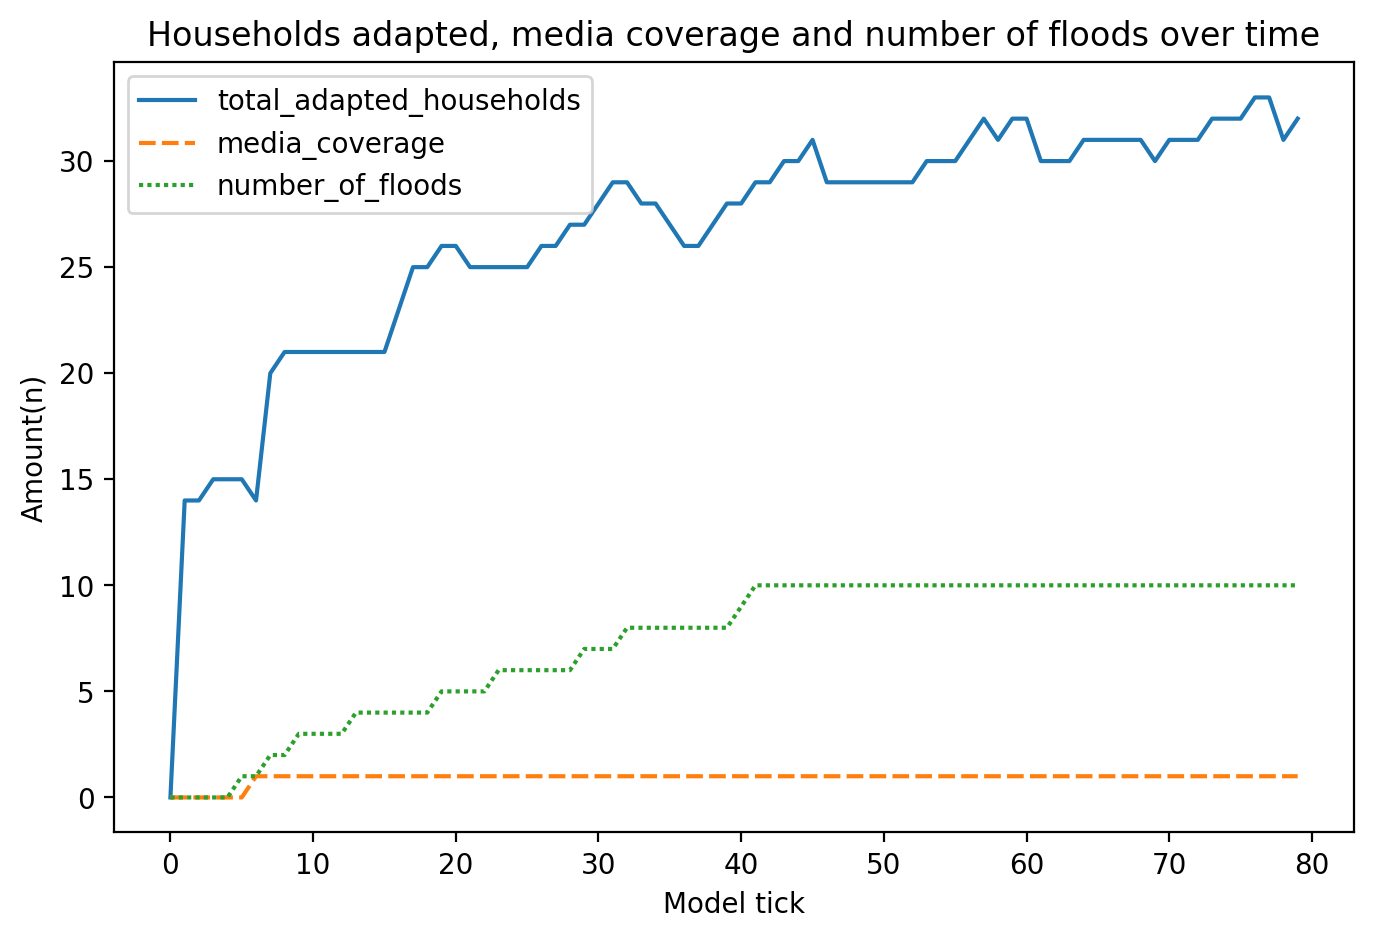

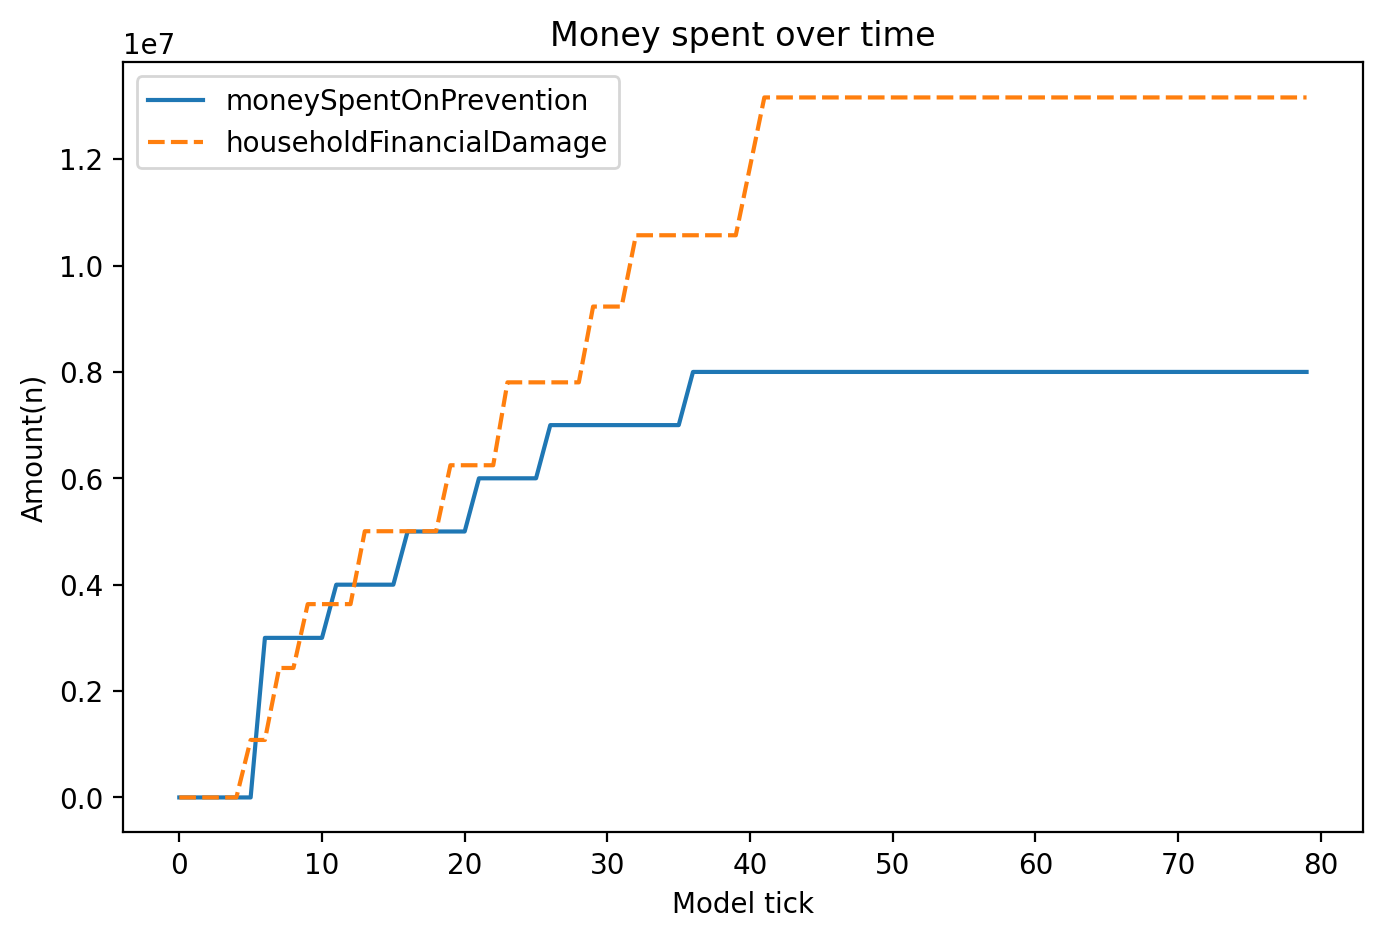

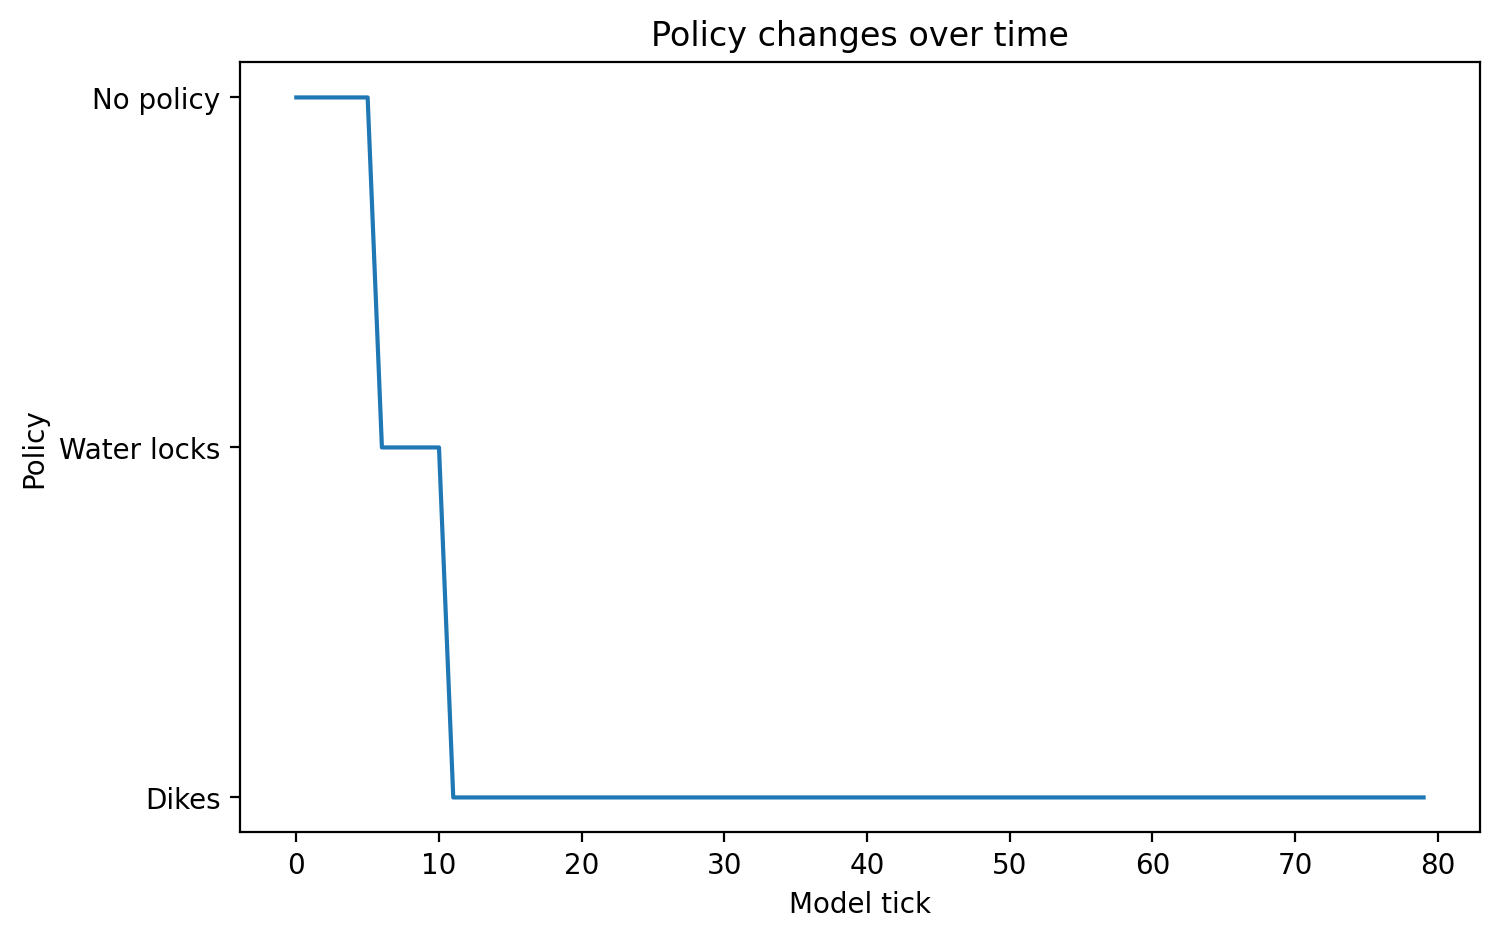

In [13]:
import seaborn as sns

#You will see that agents adapt at step 5 most because then the flood happened and only then the media will have influance on it.

fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title("Households adapted, media coverage and number of floods over time")
ax.set_xlabel("Model tick")
ax.set_ylabel("Amount(n)")
sns.lineplot(data = model_data.iloc[:, 0:3] )

fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title("Money spent over time")
ax.set_xlabel("Model tick")
ax.set_ylabel("Amount(n)")
sns.lineplot(data = model_data.iloc[:, 5:7] )


fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title("Policy changes over time")
ax.set_xlabel("Model tick")
ax.set_ylabel("Policy")
sns.lineplot(data = model_data.current_policy )
#sns.histplot(data = model_data.current_policy)

<h3><b> Estimated runtime: 2-3 minutes </b></h3>

The 3 underlying cells are nessesary for a vidio example of the model, this takes time to run and runs a new model. If you want to run in again you need to run the middle cell again to reset the model.

In [14]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
from functions import map_domain_gdf, floodplain_gdf

In [15]:
model = AdaptationModel(number_of_households=50, flood_map_choice="harvey", network="watts_strogatz", adaptation_threshold=0.2, introduce_inequality=True, number_of_steps=80) #reset the model

KeyboardInterrupt: 

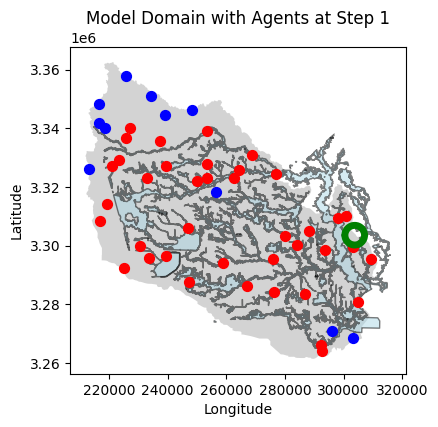

In [16]:
fig, ax = plt.subplots()

# Adjust layout to make room for annotations
fig.subplots_adjust(bottom=0.2)

# Function to plot the grid at each step
def plot_grid(model):
    ax.clear()
    
    # Plot the model domain
    map_domain_gdf.plot(ax=ax, color='lightgrey')
    #Plot the floodplain
    floodplain_gdf.plot(ax=ax, color='lightblue', edgecolor='k', alpha=0.5)

    for agent in model.schedule.agents:
        if agent.type == "household" and agent.is_adapted == False:
            #get position on the map
            ax.scatter(agent.location.x, agent.location.y, color='red', s=50)  # Bigger, hollow circle
        elif agent.type == 'household':
            if agent in model.adapted_because_government:
                ax.scatter(agent.location.x, agent.location.y, color='purple', s=50)  # Smaller, filled circle
            else:
                ax.scatter(agent.location.x, agent.location.y, color='blue', s=50)  # Smaller, filled circle
        elif agent.type == "implementation":
            if agent.policy == "Dikes":
                ax.scatter(agent.location.x, agent.location.y, facecolors = "none", linewidths=5, edgecolors='green', s=200) 
            elif agent.policy == "Water locks":
                ax.scatter(agent.location.x, agent.location.y, facecolors = "none", linewidths=5, edgecolors='yellow', s=300) 
        # Labels and title
        
    plt.title(f'Model Domain with Agents at Step {model.schedule.steps}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

# Update function for the animation
def update(frame):
    plot_grid(model)
    model.step()
    

# Create the animation
anim = FuncAnimation(fig, update, frames=model.number_of_steps-2, repeat=False, interval=200)

# Show the animation
HTML(anim.to_jshtml())

<h1> Multiple model runs </h2>

First let's define the variables that are going to be taken into the model runs. Please change this to whatever you want to check.

In [9]:
from model import AdaptationModel
import matplotlib.pyplot as plt
import networkx as nx
from functions import map_domain_gdf, floodplain_gdf

In [10]:
#start the running of multiple models
number_of_households = 50 #recommended 
number_of_zones = 2 #number of zones the floodmap will be devided into 
flood_map_choice = "harvey" #type of flood map: other choices 100yr and 500yr
network="watts_strogatz" #type of network: other choices are 'erdos_renyi', 'barabasi_albert', 'watts_strogatz', and 'no_network'
insurance=True
government_implementation=True#implementations yes/no
adaptation_threshold=0.5 #at what prospect score should the households adapt, this score is between 0 and 1, recommended to let this be 0.5
introduce_inequality=True #inequality in the economy yes/no
number_of_steps=80 #recommended to leave this at 80

How many models do you want to test? A high number will increase the run time significantly. Try to run 100 for better results. lowest amount for testing recommended: 20

In [11]:
model_amount = 20 #for good analysis run at least 100 models

Let's initialize the models <b> estimated runtime 10seconds/100 models </b>

In [12]:
model_run_queue = []

for i in range(model_amount):
    model = AdaptationModel(number_of_households=number_of_households, number_of_zones=number_of_zones, flood_map_choice=flood_map_choice, network=network, adaptation_threshold=adaptation_threshold, introduce_inequality=introduce_inequality, number_of_steps=number_of_steps, government_implementations=government_implementation, insurance=insurance)
    model_run_queue.append(model)

print(f"Initialized the models that will be generated {model_amount} times in a row. sample of queue: {model_run_queue[0:10]}")

Initialized the models that will be generated 20 times in a row. sample of queue: [<model.AdaptationModel object at 0x000002D837269520>, <model.AdaptationModel object at 0x000002D8373AF430>, <model.AdaptationModel object at 0x000002D83742F550>, <model.AdaptationModel object at 0x000002D83756C580>, <model.AdaptationModel object at 0x000002D83758D5B0>, <model.AdaptationModel object at 0x000002D8375C45E0>, <model.AdaptationModel object at 0x000002D8375ED610>, <model.AdaptationModel object at 0x000002D837619640>, <model.AdaptationModel object at 0x000002D837638670>, <model.AdaptationModel object at 0x000002D8374476A0>]


Now let's run all these models. <b> estimated runtime 100seconds/100 models </b>

In [13]:
for model in model_run_queue:
    for step in range(model.number_of_steps):
        model.step()

Now let's collect the data for all the models

In [14]:
agent_data_multiple_runs = []
model_data_multiple_runs = []

for model in model_run_queue:
    agent_data = model.datacollector.get_agent_vars_dataframe()
    agent_data_multiple_runs.append(agent_data)
    
    model_data = model.datacollector.get_model_vars_dataframe()
    model_data_multiple_runs.append(model_data)

<h1> Visualisation </h1>

Let's see how many households adapt over multiple runs, looks to go towards a limit

<AxesSubplot: title={'center': 'Households adapted over time on average over 20 model runs'}, xlabel='Model tick', ylabel='Amount(n)'>

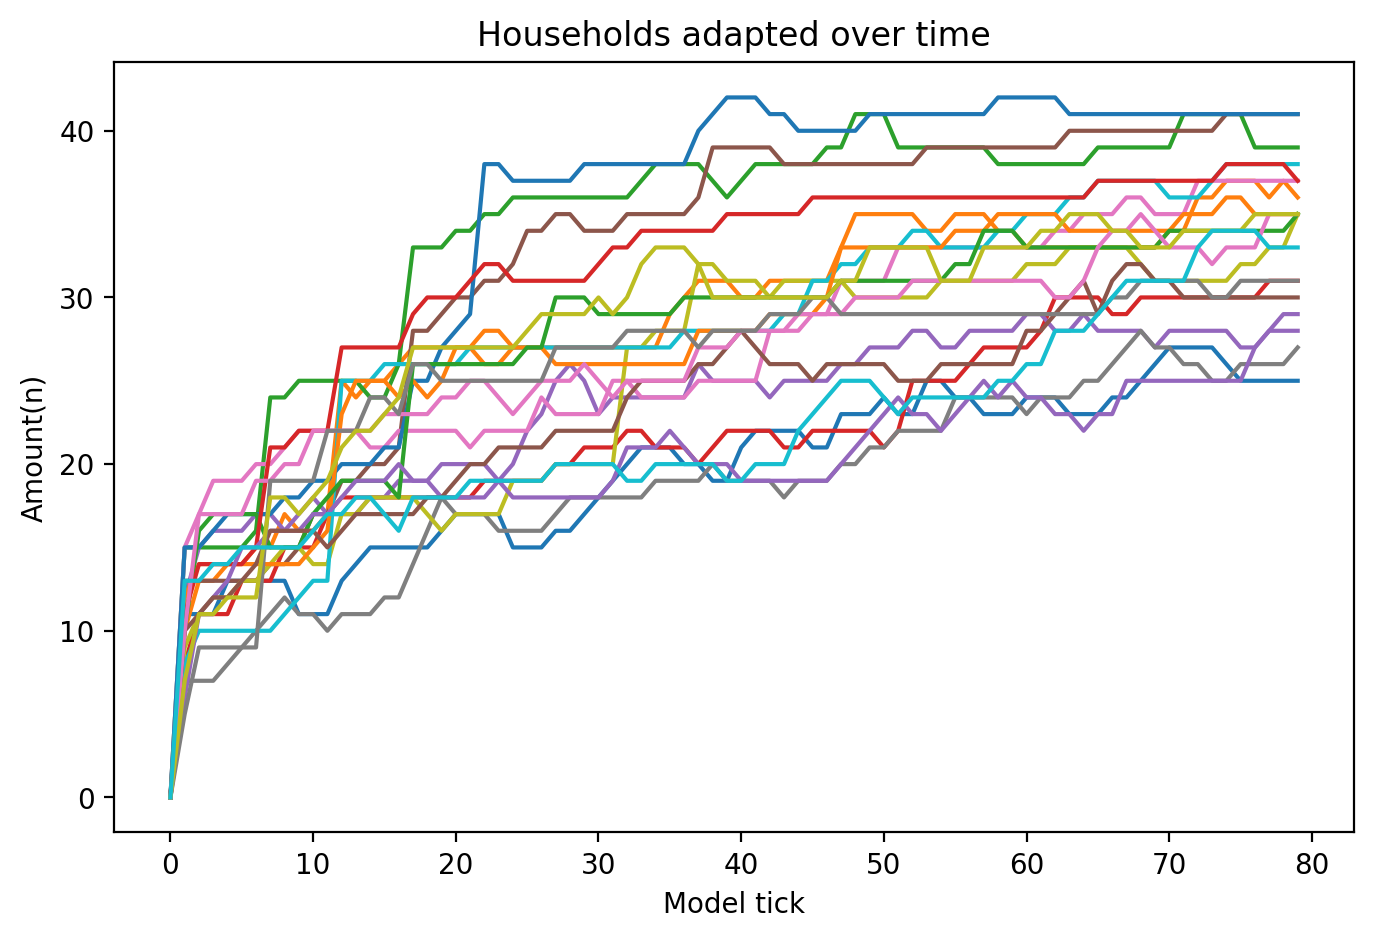

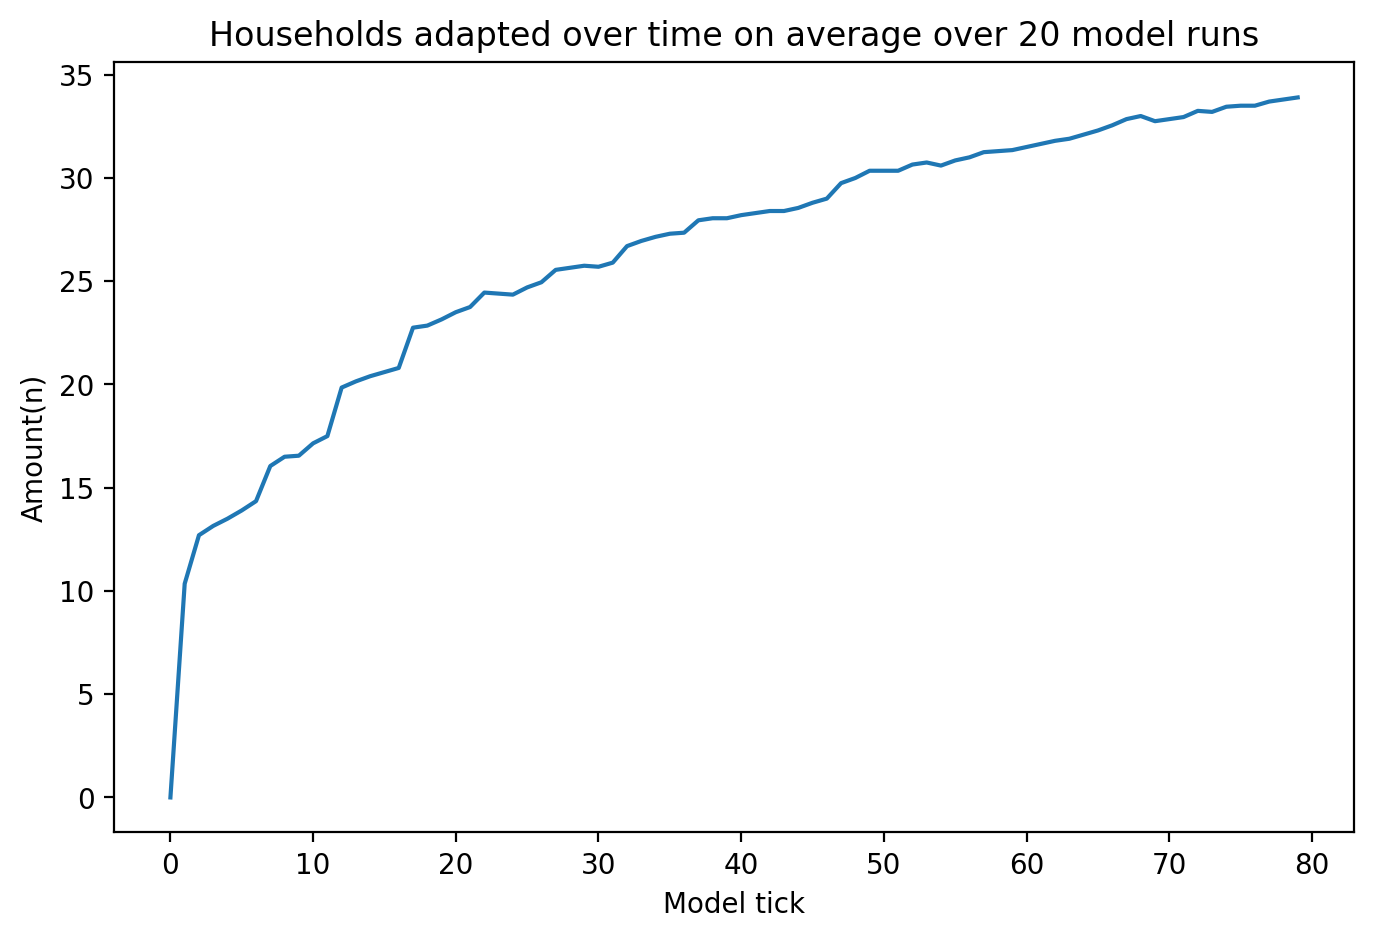

In [15]:
import seaborn as sns

#You will see that agents adapt at step 5 most because then the flood happened and only then the media will have influance on it.
fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title("Households adapted over time")
ax.set_xlabel("Model tick")
ax.set_ylabel("Amount(n)")
for data in model_data_multiple_runs:
    sns.lineplot(data = data.total_adapted_households , legend=None)

#let's now take the average of the adapted households


#this algorithm fills the list of average adapted households over the number of steps, probably a simpler way but I am lazy
def get_average(choice):
    average_adapted_households = []
    for num, data in enumerate(model_data_multiple_runs):
        base_list=data[choice]
        for num2, i in enumerate(base_list):
            if num == 0:
                average_adapted_households.append(i)
            else:
                average_adapted_households[num2] = average_adapted_households[num2] + i
 
    for i, j in enumerate(average_adapted_households):
        average_adapted_households[i] = average_adapted_households[i]/model_amount
        
    return average_adapted_households

fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title(f"Households adapted over time on average over {model_amount} model runs")
ax.set_xlabel("Model tick")
ax.set_ylabel("Amount(n)")
sns.lineplot(data = get_average("total_adapted_households") , legend=None)
        

Let's also see the average number of floods, here it looks to be linear but please test this as I am now working on 20 runs which is too little

<AxesSubplot: title={'center': 'average number of floods over 20 model runs'}, xlabel='Model tick', ylabel='Amount(n)'>

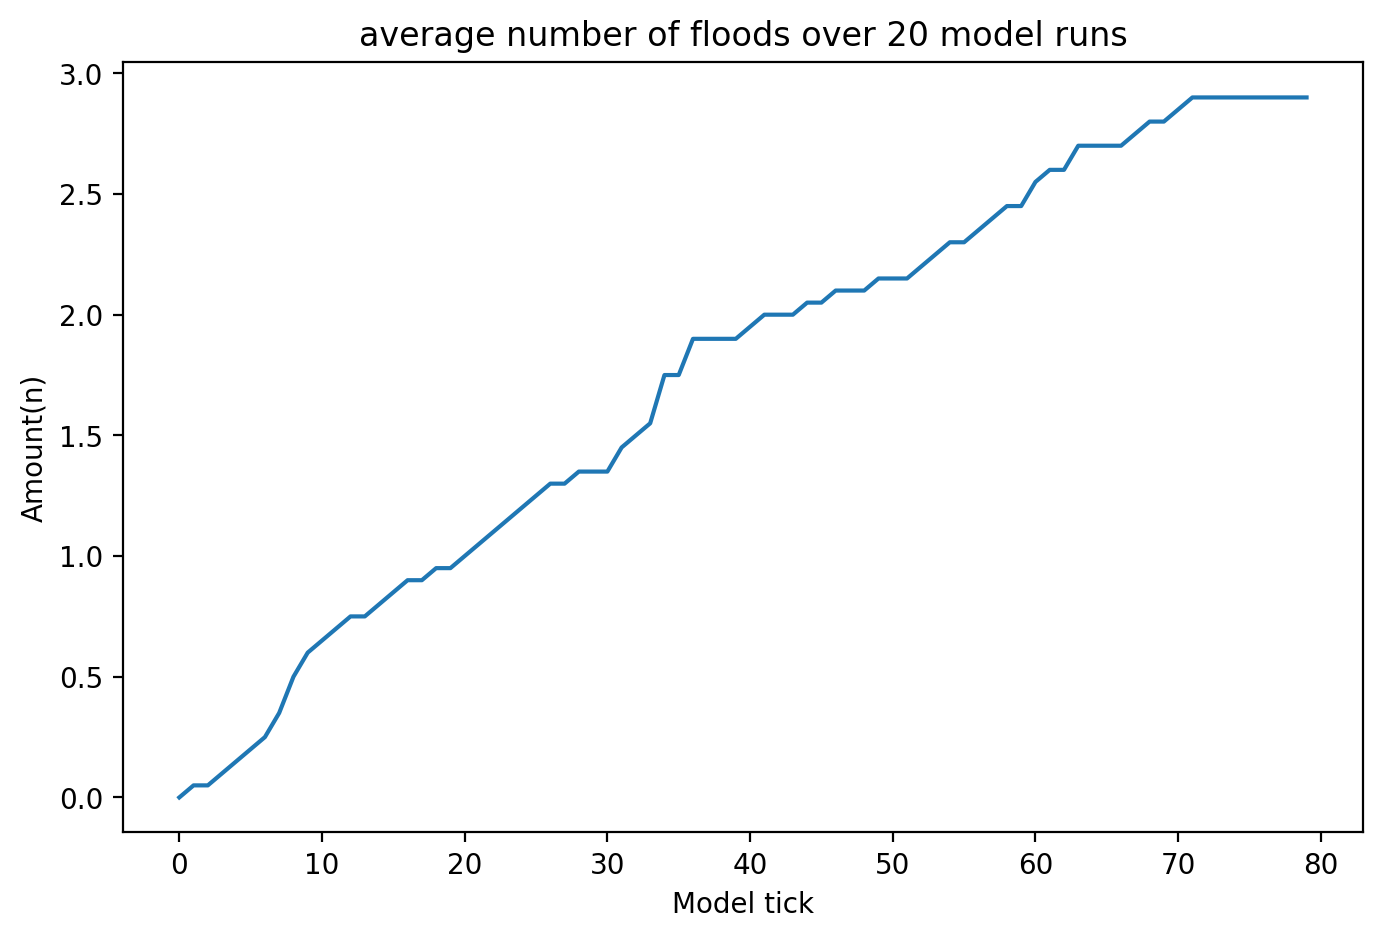

In [16]:
fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title(f"average number of floods over {model_amount} model runs")
ax.set_xlabel("Model tick")
ax.set_ylabel("Amount(n)")
sns.lineplot(data = get_average("number_of_floods") , legend=None)

Let's see it for the media attention, looks to have a limit around 1.5

<AxesSubplot: title={'center': 'average media attention over 20 model runs'}, xlabel='Model tick', ylabel='Amount(n)'>

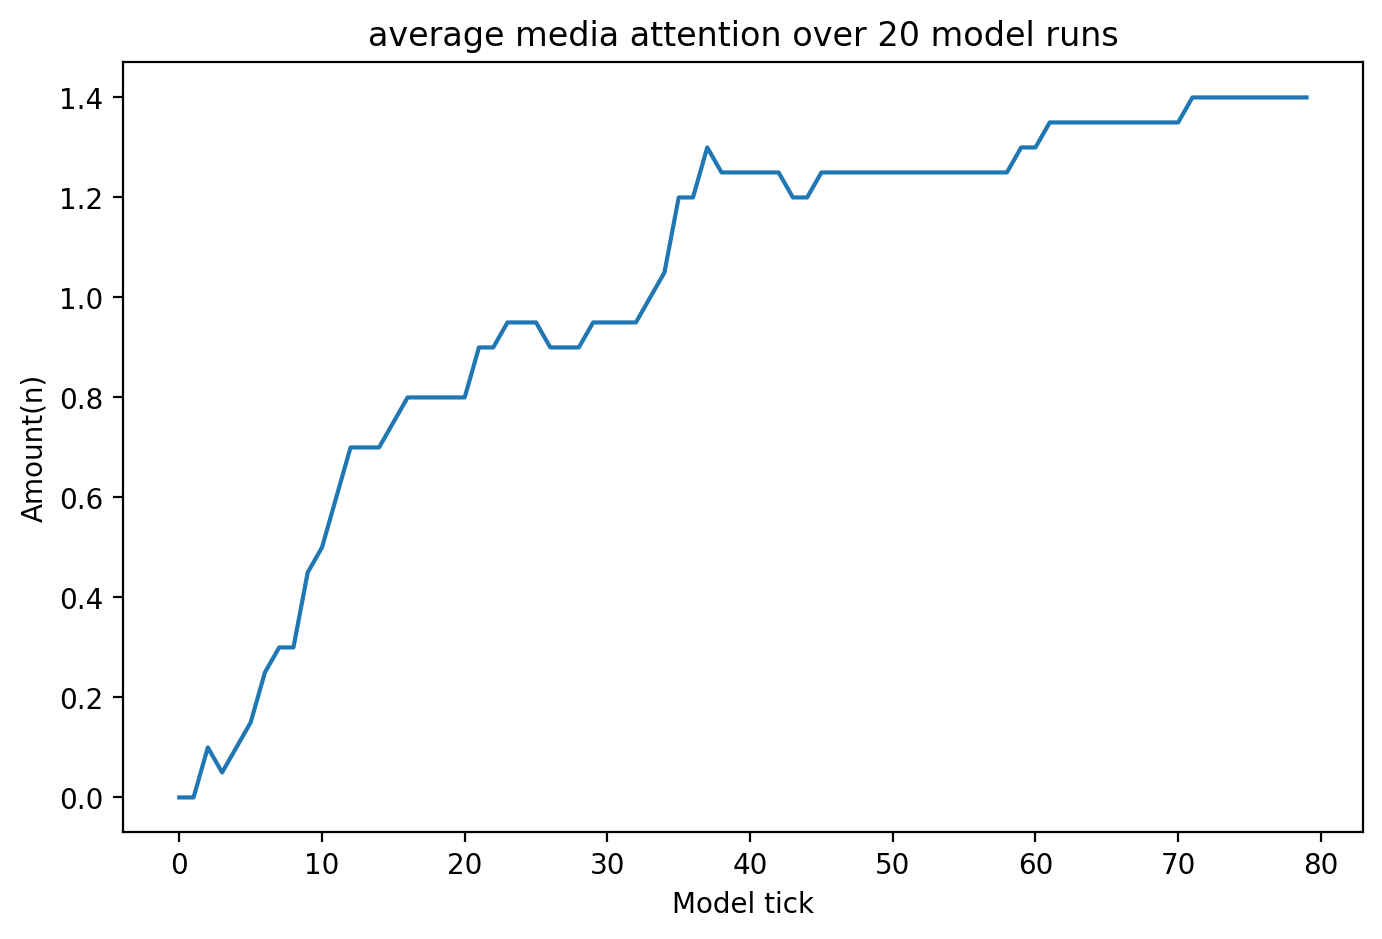

In [17]:
fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title(f"average media attention over {model_amount} model runs")
ax.set_xlabel("Model tick")
ax.set_ylabel("Amount(n)")
sns.lineplot(data = get_average("media_coverage") , legend=None)

In the cell below all the averages are put in one graph

<AxesSubplot: title={'center': 'Over 20 model runs'}, xlabel='Model tick', ylabel='Amount(n)'>

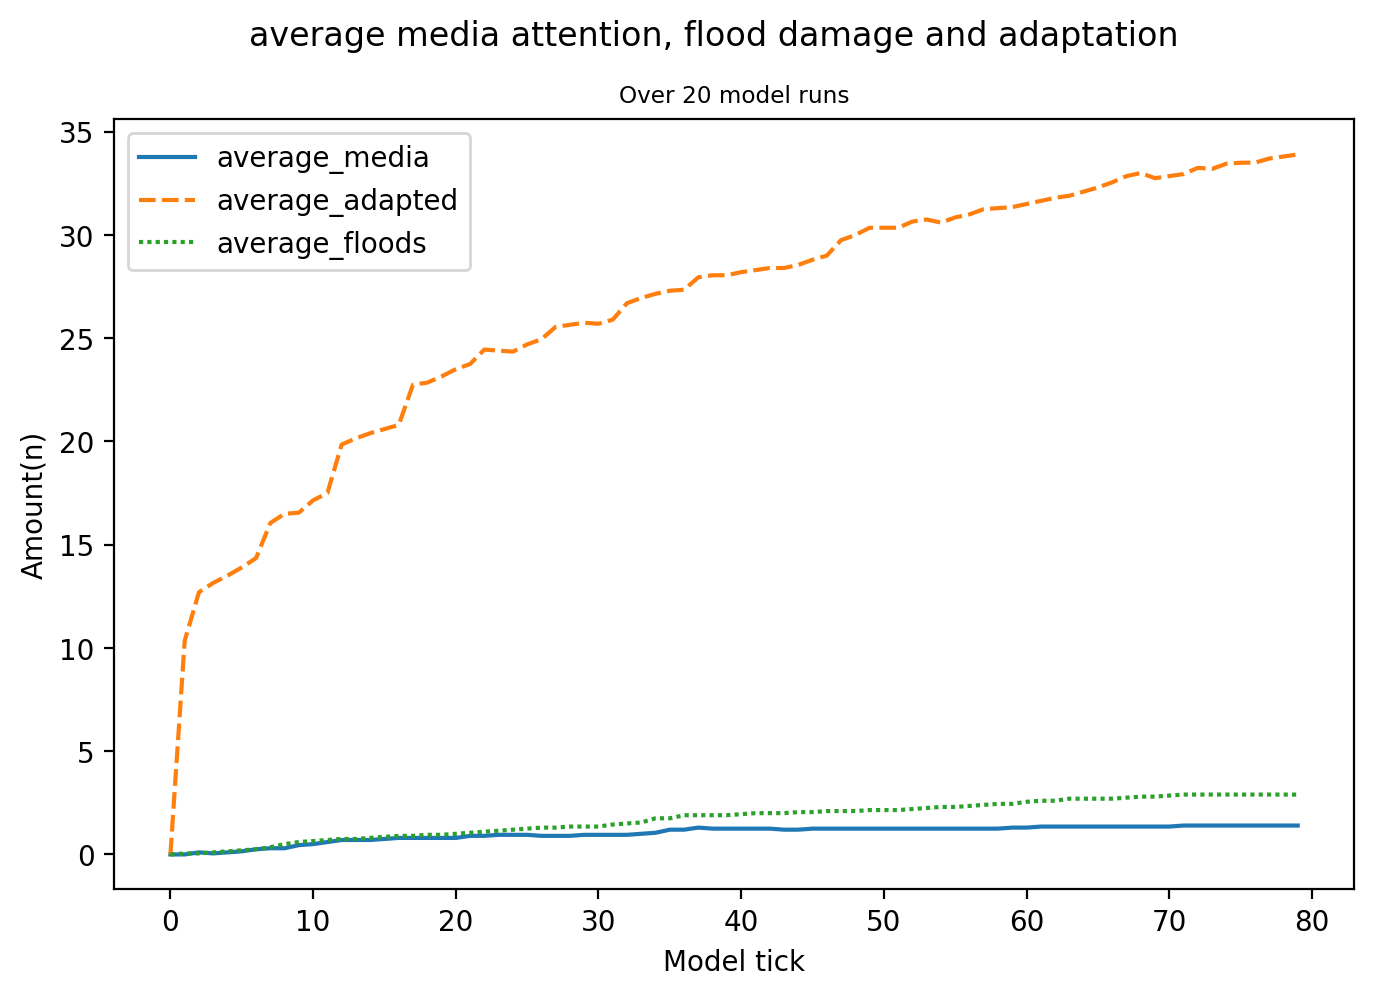

In [18]:
import pandas as pd

average_media = get_average("media_coverage")
average_floods = get_average("number_of_floods") ,
average_adapted = get_average("total_adapted_households")

df = pd.DataFrame()
df["average_media"] = average_media
df["average_adapted"] = average_adapted
df["average_floods"] = average_floods[0] #per ongeluk een touple geworden oops, maar dit werkt ook 


fig, ax = plt.subplots(figsize=(8,5), dpi=200 )
ax.set_xlabel("Model tick")
ax.set_ylabel("Amount(n)")
plt.suptitle(f"average media attention, flood damage and adaptation")
plt.title(f"Over {model_amount} model runs", size="small")
sns.lineplot(data = df)

The cell below shows the average money the government has spent on all the implementations versus the amount of damages households get from all the floods. Household loss is modelled by flood damage times the money the agent has with the assumption richer agents will see higher financial damage than poorer agents because they have more expensive housing and objects.

<AxesSubplot: title={'center': 'Over 20 runs'}, xlabel='Model tick', ylabel='Euro'>

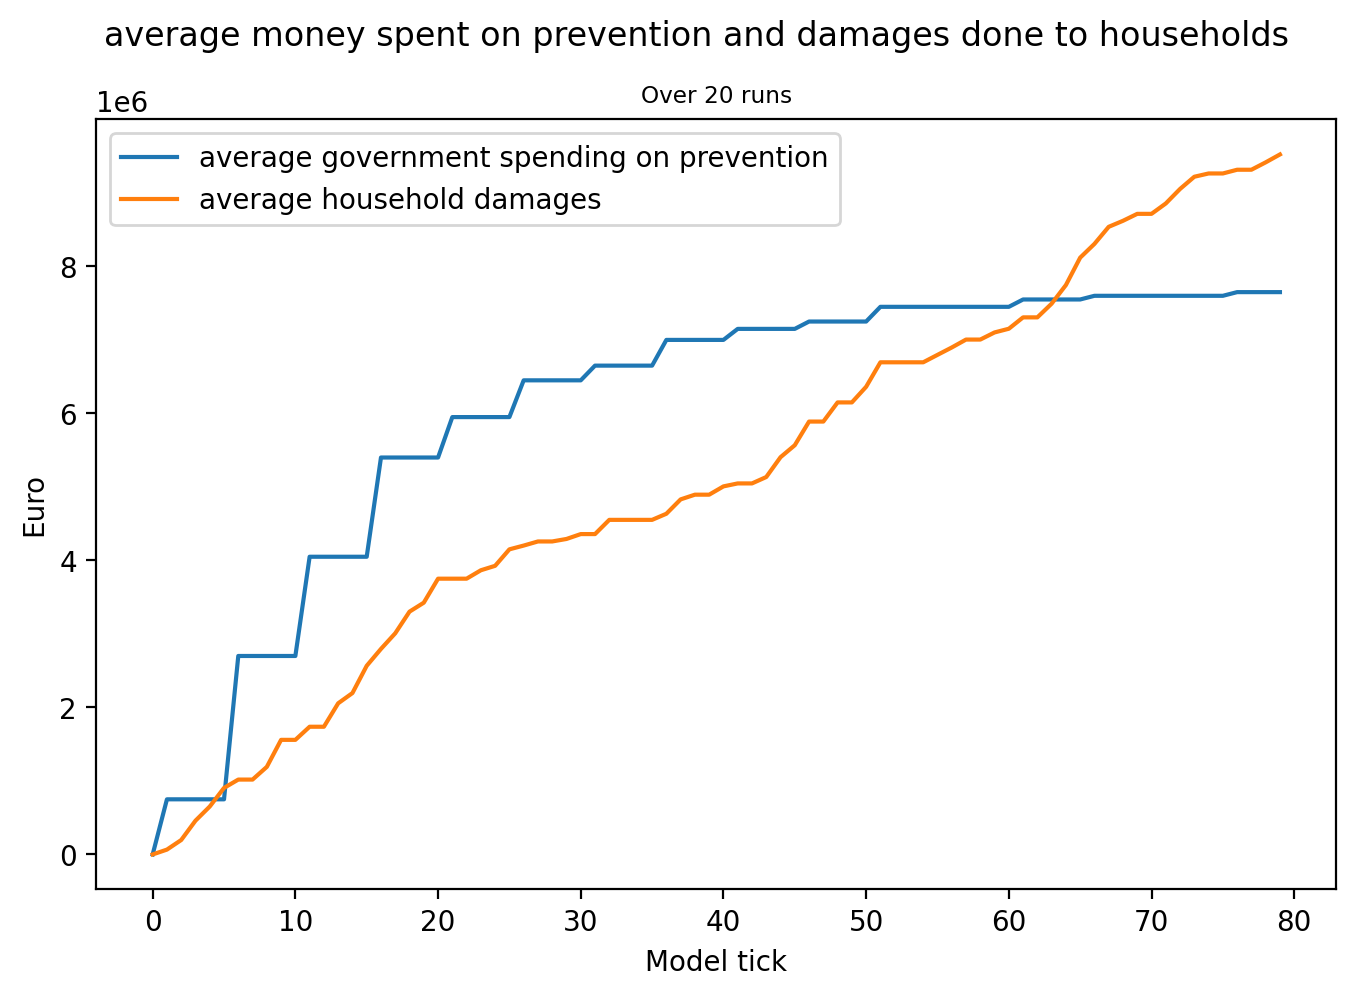

In [27]:
fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.suptitle(f"average money spent on prevention and damages done to households")
plt.title(f"Over {model_amount} runs", size="small")
ax.set_xlabel("Model tick")
ax.set_ylabel("Euro")
sns.lineplot(data = get_average("moneySpentOnPrevention"), label="average government spending on prevention" )
sns.lineplot(data = get_average("householdFinancialDamage"), label="average household damages" )

Let's see how what the policies ware that the government implemented in the model runs 

{'Dikes': 96, 'Water Locks': 19, 'No policy': 4}


<AxesSubplot: title={'center': 'Note that there can be water locks and Dikes so it will not always add to 100'}, xlabel='Type of policy', ylabel='Policy'>

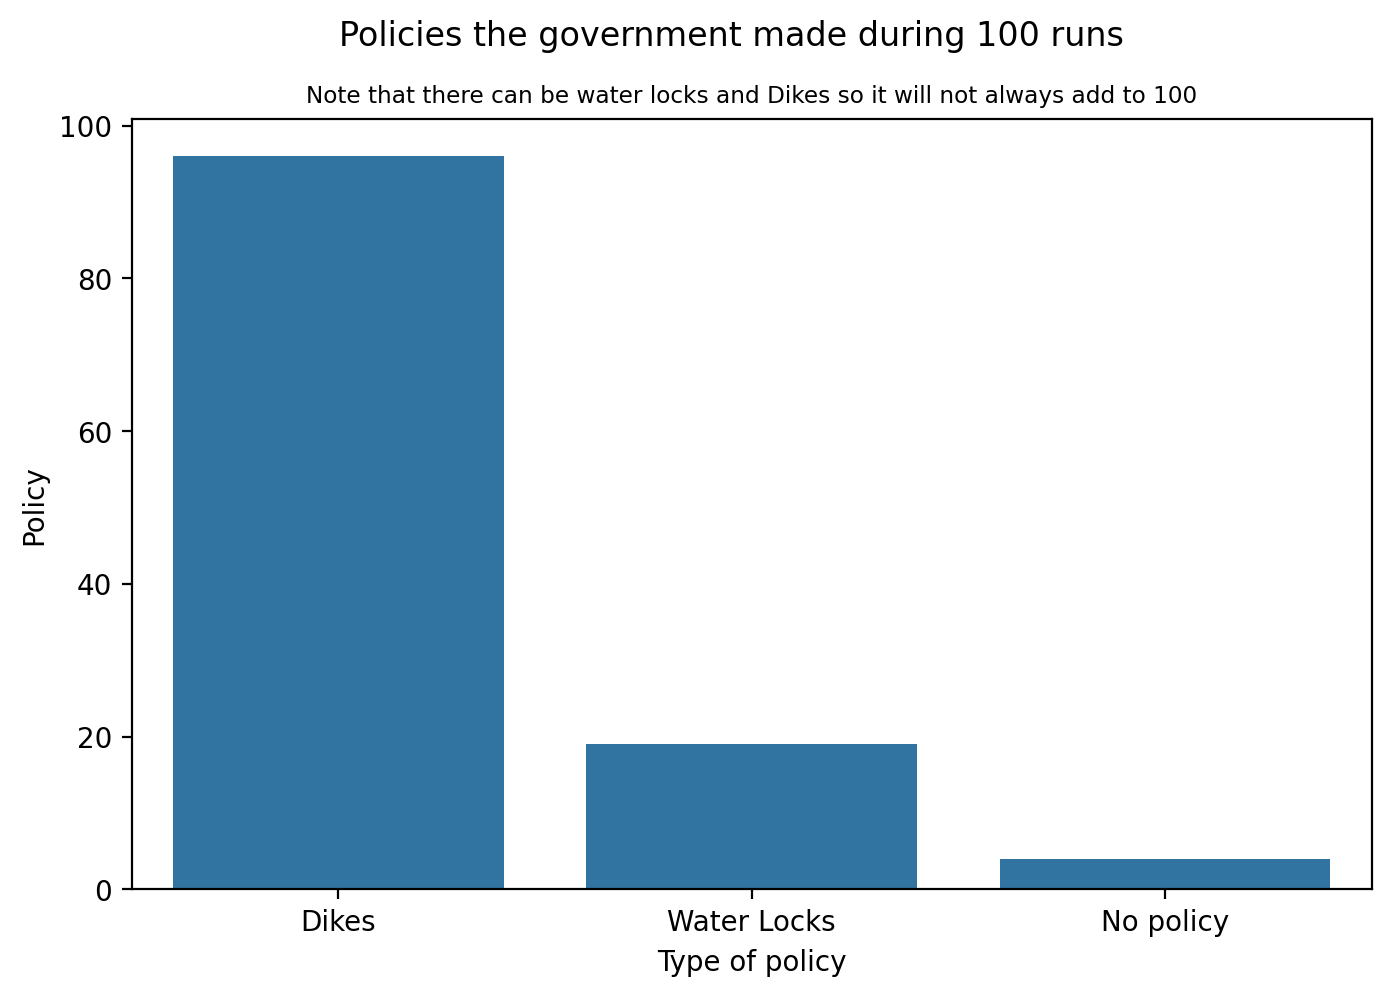

In [19]:
fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.suptitle(f"Policies the government made during {model_amount} runs")
plt.title(f"Note that there can be water locks and Dikes so it will not always add to {model_amount}", size="small")
ax.set_xlabel("Type of policy")
ax.set_ylabel("Policy")

policies = {
    "Dikes": 0,
    "Water Locks": 0,
    "No policy": 0,
}

for data in model_data_multiple_runs:
    dikes_added = False
    water_locks_added = False
    for implementation in data.current_policy:
        if implementation == "Dikes" and dikes_added == False:
            policies["Dikes"] += 1  
            dikes_added = True     
        elif implementation == "Water locks" and water_locks_added == False:
            policies["Water Locks"] += 1
            water_locks_added = True
    
    if data.current_policy[number_of_steps-1] == "No policy":
        policies["No policy"] += 1

print(policies)
sns.barplot(data = policies)
#sns.histplot(data = model_data.current_policy)

<h4> <b> Let's check out the economy over the model runs </b> </h4>

In the following code the average income of all households over the model runs will be calculated and displayed 

Let's remove the not households agents. <b> estimated runtime 10seconds </b>

In [21]:
household_data_multiple_runs = []
government_data_multiple_runs = []
insurance_data_multiple_runs = []

for agent_data in agent_data_multiple_runs:
    household_data = agent_data
    government_data = agent_data
    insurance_data = agent_data
    for i,j in enumerate(household_data.Type[number_of_steps-1]):
        if j != "household":
            household_data = household_data.drop(i, level="AgentID")
        if j != "government":
            government_data = government_data.drop(i, level="AgentID")
        if j != "insurance":
            insurance_data = insurance_data.drop(i, level="AgentID")

    household_data_multiple_runs.append(household_data)
    government_data_multiple_runs.append(government_data)
    insurance_data_multiple_runs.append(insurance_data)

insurance_data_multiple_runs[0].tail()

Type  FloodDepthEstimated  FloodDamageEstimated  \
Step AgentID                                                         
75   52       insurance                  NaN                   NaN   
76   52       insurance                  NaN                   NaN   
77   52       insurance                  NaN                   NaN   
78   52       insurance                  NaN                   NaN   
79   52       insurance                  NaN                   NaN   

              FloodDepthActual  FloodDamageActual IsAdapted Currentadaptation  \
Step AgentID                                                                    
75   52                    NaN                NaN      None              None   
76   52                    NaN                NaN      None              None   
77   52                    NaN                NaN      None              None   
78   52                    NaN                NaN      None              None   
79   52                    NaN                NaN      None              None   

                     Money IsInsured  FriendsCount location  
Step AgentID                                                 
75   52       1.293981e+06      None           NaN     None  
76   52       1.298635e+06      None           NaN     None  
77   52       1.303290e+06      None           NaN     None  
78   52       1.307944e+06      None           NaN     None  
79   52       1.312598e+06      None           NaN     None

This algorithm will create a dict with the model run number and than a list of the average money for each step

In [22]:
average_money_multiple_runs = {

}

for run, agent_data in enumerate(household_data_multiple_runs):
    average_money_per_step = []
    average_money = 0
    #for each run we want a list of the average money for each step
    for num, money in enumerate(agent_data.Money):
        if num != 0 and num % number_of_households == 0:
            average_money = average_money/number_of_households
            average_money_per_step.append(average_money)
            average_money = 0
        average_money += money
    print(f"This value should be 80 steps -1 = 79 --> {len(average_money_per_step)}", end="\r")
    average_money_multiple_runs[run] = average_money_per_step
        

Here the economy will be visualised 

<AxesSubplot: title={'center': 'Note that this is the average of all households and says nothing about inequality. Each line is a model.'}, xlabel='Model tick', ylabel='Amount(n)'>

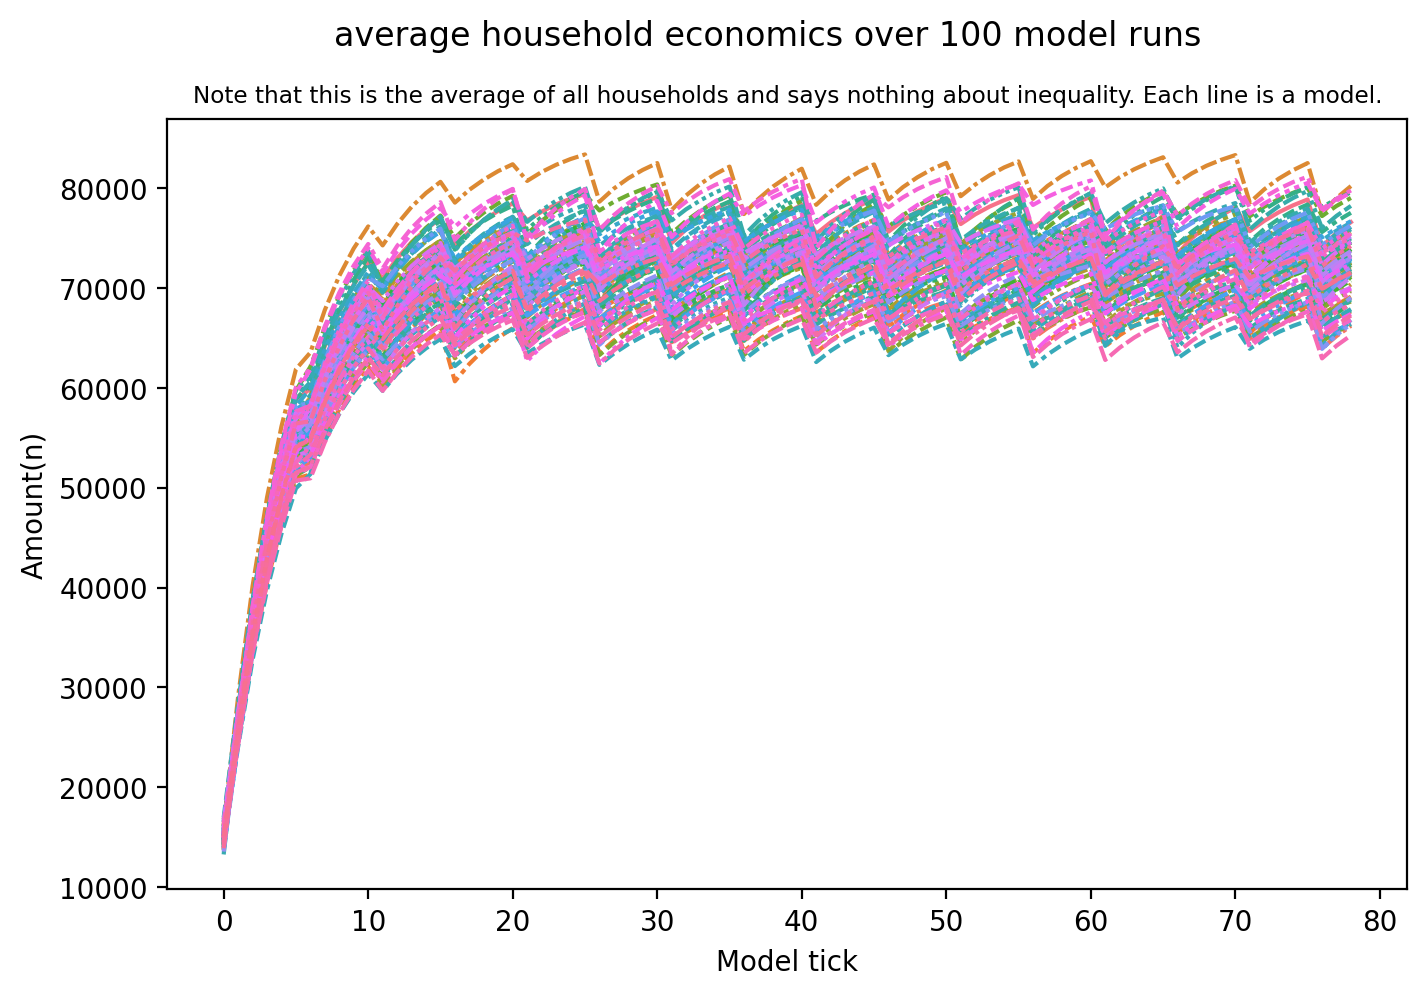

In [23]:
fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title(f"Note that this is the average of all households and says nothing about inequality. Each line is a model.", size="small")
plt.suptitle(f"average household economics over {model_amount} model runs")
ax.set_xlabel("Model tick")
ax.set_ylabel("Amount(n)")
sns.lineplot(data = average_money_multiple_runs , legend=None)

In the following code the government and insurance economics are gathered for all the runs 

In [24]:
money_government_multiple_runs = {

}
money_insurance_multiple_runs = {

}

for run, government_data in enumerate(government_data_multiple_runs):
    money_per_step = []
    for money in government_data.Money: #there is only one government so that makes this easier
        money_per_step.append(money)
    money_government_multiple_runs[run] = money_per_step

for run, insurance_data in enumerate(insurance_data_multiple_runs):
    money_per_step = []
    for money in insurance_data.Money: #there is only one government so that makes this easier
        money_per_step.append(money)
    money_insurance_multiple_runs[run] = money_per_step



The following block visualises this: here we can see that a lot of measurements can be too expensive and some runs make the government reach 0. 

<AxesSubplot: title={'center': 'Each line gives the trajectory of the funds a government has'}, xlabel='Model tick', ylabel='Euro'>

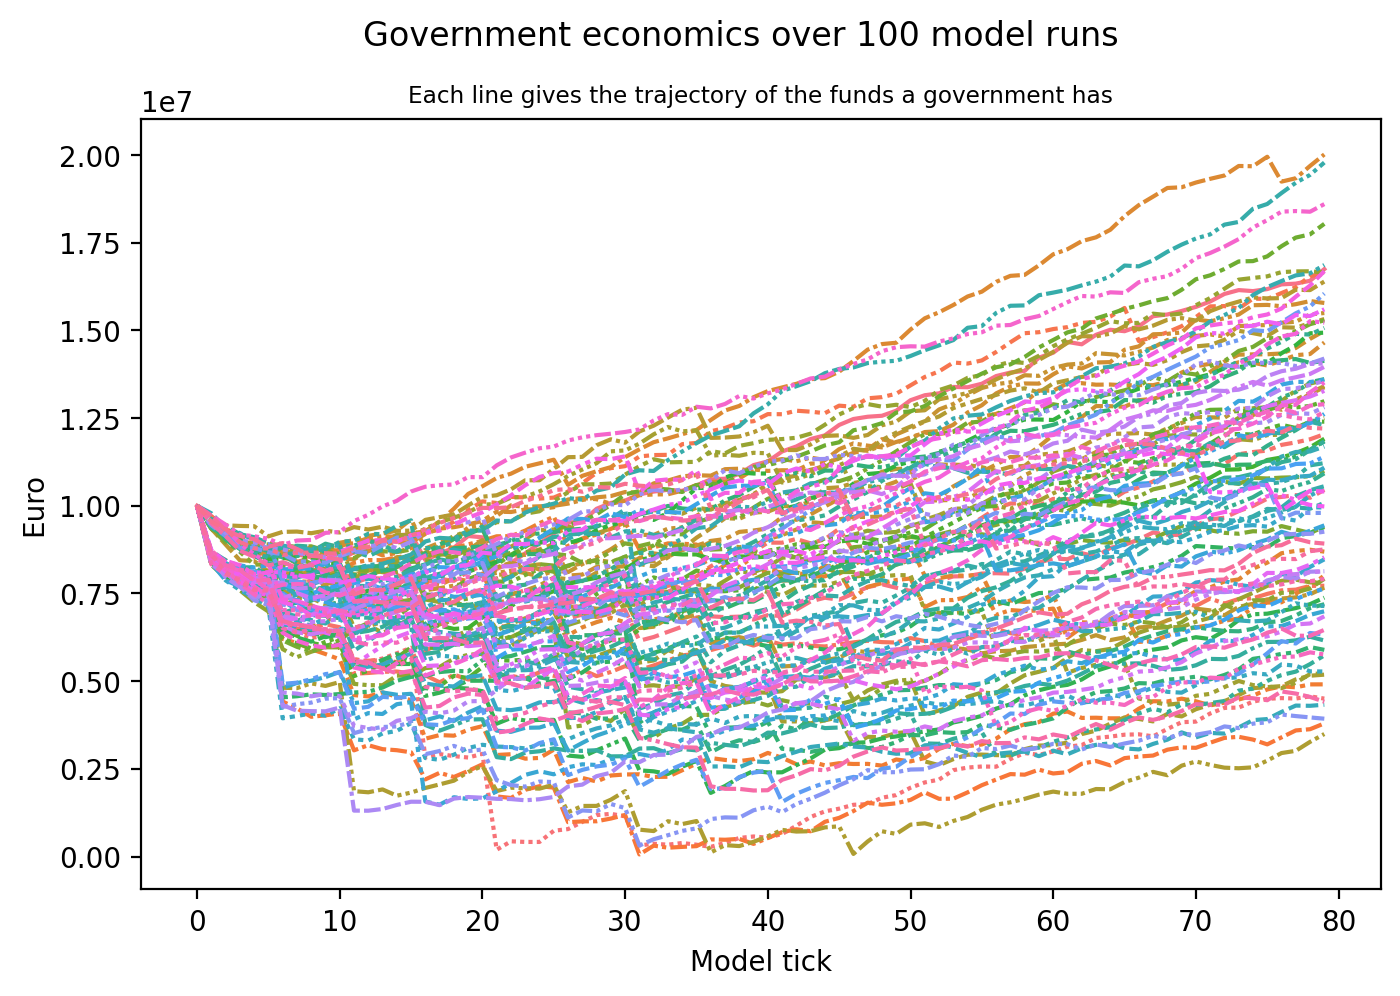

In [25]:
fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title(f"Each line gives the trajectory of the funds a government has", size="small")
plt.suptitle(f"Government economics over {model_amount} model runs")
ax.set_xlabel("Model tick")
ax.set_ylabel("Euro")
sns.lineplot(data = money_government_multiple_runs, legend=None)

This is a bit chaotic so we can narrow this down to a single line that shows the average of each step over the multiple runs.

In [26]:
government_money_average ={

}
for i in range(number_of_steps):
    government_money_average[i] = 0
    for run, money_list in money_government_multiple_runs.items():
        government_money_average[i] += money_list[i]/model_amount

print(government_money_average)
    

{0: 10000000.0, 1: 8852159.23079871, 2: 8505302.216844063, 3: 8255965.527245489, 4: 8091497.281675988, 5: 7999685.340854119, 6: 7345293.985712854, 7: 7288341.912944118, 8: 7255179.821557116, 9: 7272829.03483903, 10: 7307958.31037577, 11: 6880176.952489567, 12: 6941082.493446131, 13: 7003843.595918218, 14: 7084430.237118969, 15: 7171998.831720707, 16: 6768765.997034077, 17: 6838118.057328889, 18: 6915453.7221423155, 19: 7021802.964699089, 20: 7136865.590258612, 21: 6695198.768172454, 22: 6773772.4756274065, 23: 6853385.0842623105, 24: 6954053.284432841, 25: 7052922.87877873, 26: 6709133.233985334, 27: 6777865.45450031, 28: 6887198.2786968, 29: 6998084.829456382, 30: 7117182.774872755, 31: 6834068.456643998, 32: 6918367.416361153, 33: 7007116.267483845, 34: 7090475.746310512, 35: 7212275.330179137, 36: 7053644.328372428, 37: 7146542.497675665, 38: 7240648.874163508, 39: 7338946.1539465105, 40: 7456382.862861807, 41: 7392654.593475542, 42: 7475462.838974952, 43: 7567313.574270768, 44: 767

The graph below has some interesting caractaristics, I suspect the money goes down by a lot in the start because households do not have enough money to pay taxes with. This increases as you can see in other graphs and stabalises the government funds. You can see that once enough households have adapted the economy grows.

<AxesSubplot: title={'center': 'average amount of funds the government has to its name'}, xlabel='Model tick', ylabel='Euro'>

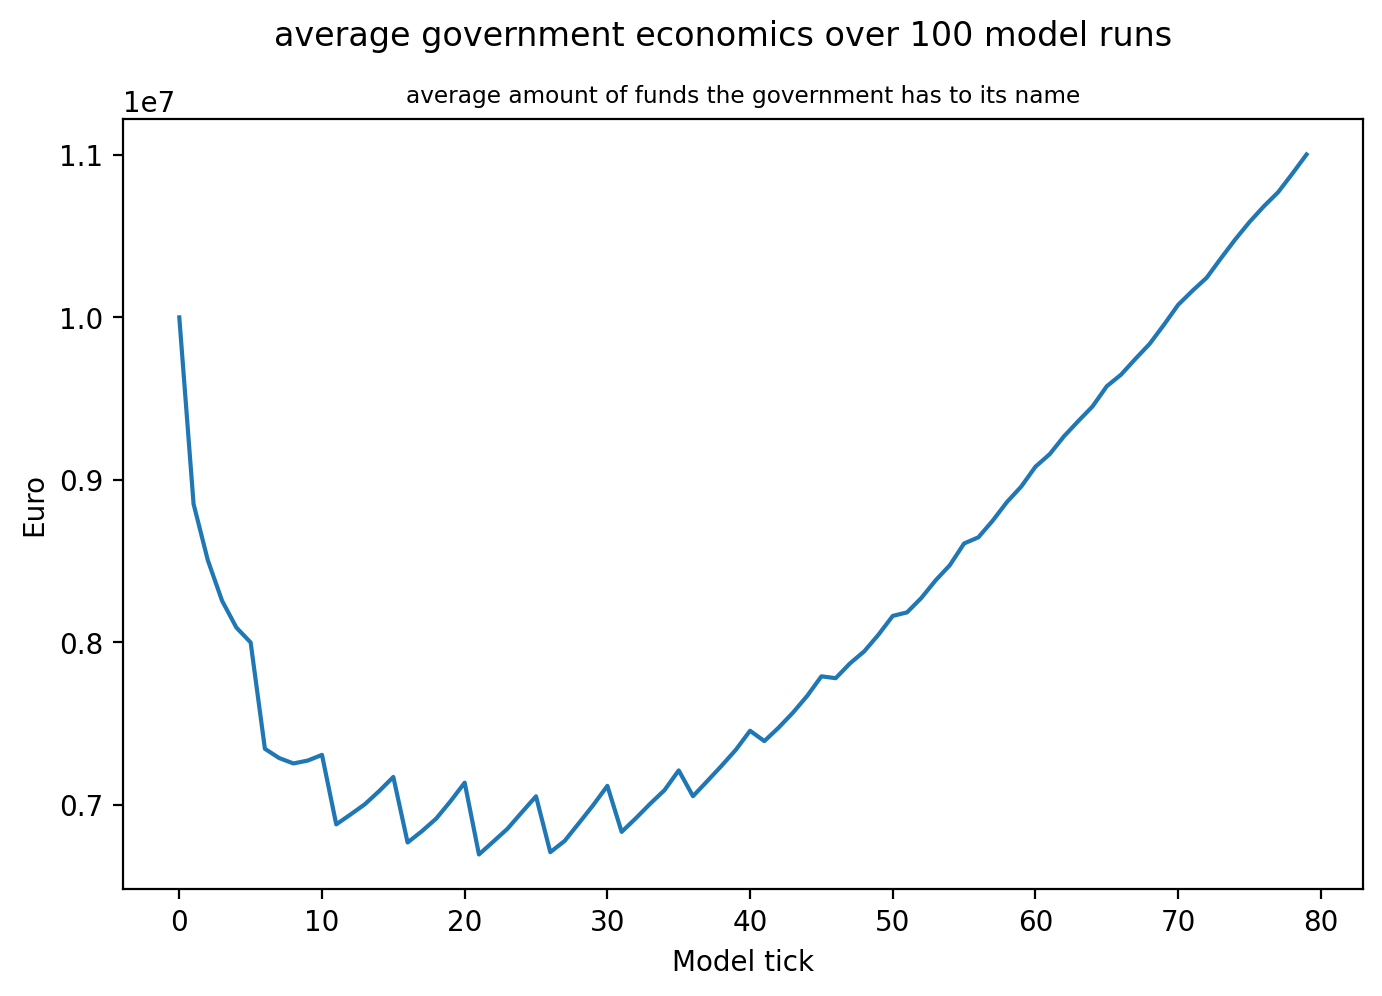

In [27]:
fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.title(f"average amount of funds the government has to its name", size="small")
plt.suptitle(f"average government economics over {model_amount} model runs")
ax.set_xlabel("Model tick")
ax.set_ylabel("Euro")
sns.lineplot(data = government_money_average , legend=None)

Finally we can see what the economics of the insurance are doing. Looks to be very linear with almost no losses. It is not programmed in a very realistic difficult way so this is to be expected.

<AxesSubplot: xlabel='Model tick', ylabel='Euro'>

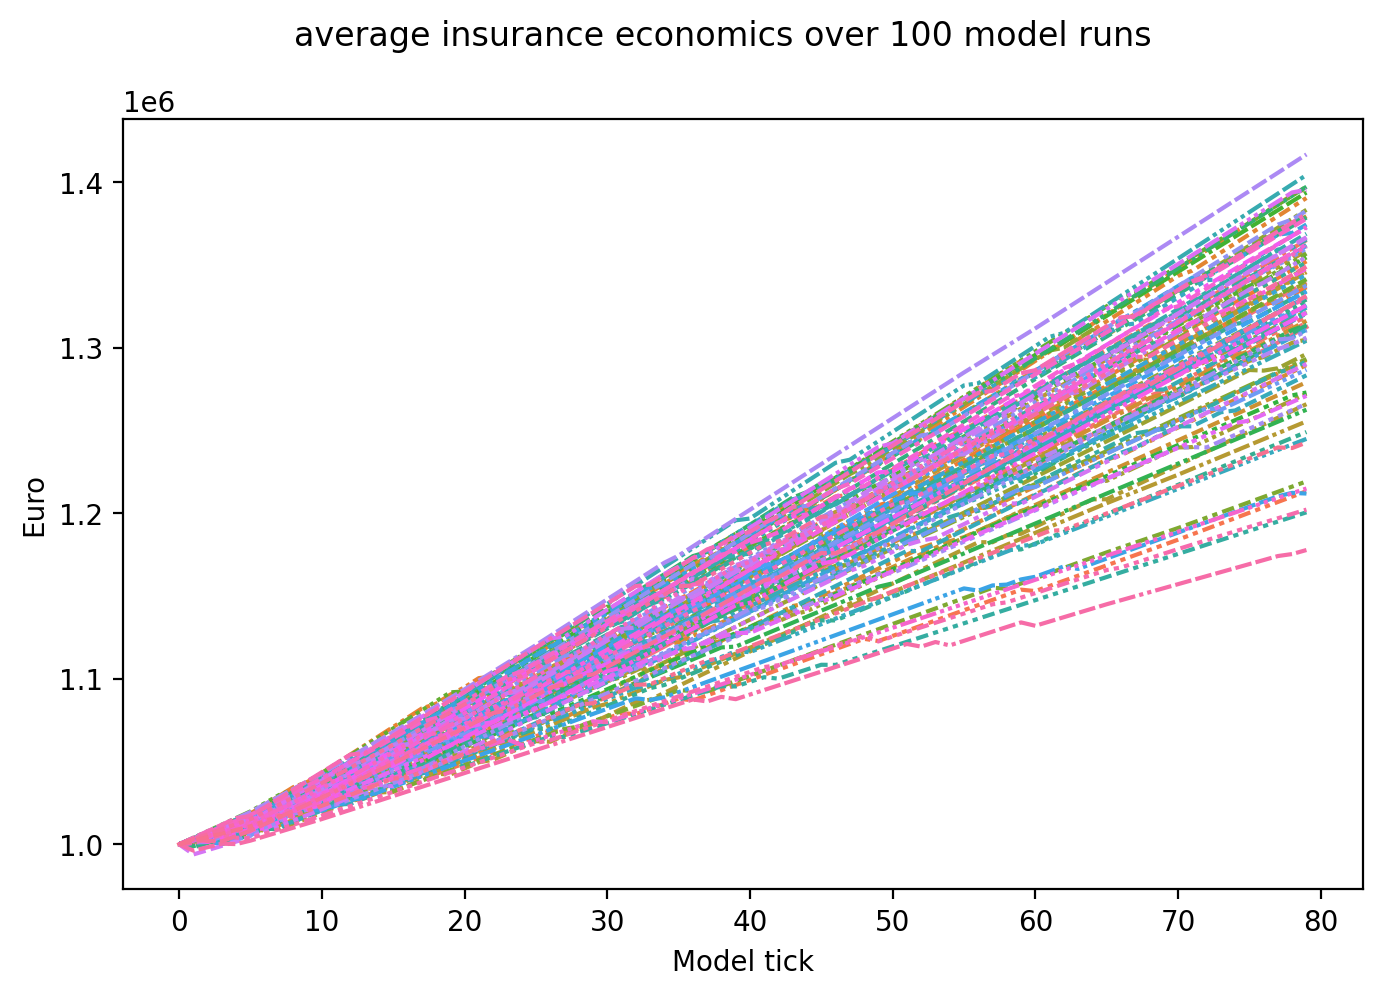

In [28]:
fig, ax = plt.subplots(figsize=(8,5), dpi=200)
plt.suptitle(f"average insurance economics over {model_amount} model runs")
ax.set_xlabel("Model tick")
ax.set_ylabel("Euro")
sns.lineplot(data = money_insurance_multiple_runs , legend=None)